# 貸款核准預測 - 探索性數據分析 (EDA)

## 專案概述
本筆記本針對貸款核准數據集進行全面的探索性數據分析，包含：
- 數據載入與基本描述
- 數據類型檢查與分析
- 分類變數與目標變數的關係分析
- 連續變數的分布與統計分析
- 數據預處理與特徵工程
- 模型建立與超參數優化

## 目錄
1. [環境設置與套件導入](#環境設置)
2. [數據載入與基本檢查](#數據載入)
3. [數據類型分析](#數據類型)
4. [視覺化分析](#視覺化分析)
5. [數據預處理](#數據預處理)
6. [模型建立與優化](#模型建立)
7. [結果分析](#結果分析)

In [ ]:
# =============================================================================
# 環境設置與套件導入
# =============================================================================

# 基本數據處理套件
import pandas as pd
import numpy as np

# 視覺化套件
import matplotlib.pyplot as plt
import seaborn as sns

# 機器學習套件
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# 梯度提升套件
import lightgbm as lgb
import xgboost as xgb

# AutoML 套件
from pycaret.classification import *

# 自定義預處理模組
from preprocessing import Preprocessor

# 自動化 EDA 套件
import sweetviz as sv

# 超參數優化套件
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import logging
import warnings

# 設置
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

ModuleNotFoundError: No module named 'preprocessing'

: 

# 1. 數據載入與基本描述 {#數據載入}

本章節包含數據的載入、基本形狀檢查和初步數據品質評估。

## 1.1 載入數據集並檢查基本資訊

In [ ]:
# 載入訓練和測試數據集
train_df = pd.read_csv('playground-series-s4e10/train.csv')
test_df = pd.read_csv('playground-series-s4e10/test.csv')

# 顯示數據集基本資訊
print("=" * 50)
print("數據集基本資訊")
print("=" * 50)
print(f'訓練數據形狀: {train_df.shape}')
print(f'測試數據形狀: {test_df.shape}')

print("\n訓練數據缺失值統計:")
missing_values = train_df.isna().sum()
print(missing_values[missing_values > 0]) if missing_values.sum() > 0 else print("無缺失值")

print("\n測試數據缺失值統計:")
missing_values_test = test_df.isna().sum()
print(missing_values_test[missing_values_test > 0]) if missing_values_test.sum() > 0 else print("無缺失值")

Training data shape:(58645, 13)
Testing data shape:(39098, 12)


id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [ ]:
# 檢查數據類型
print("訓練數據各欄位數據類型:")
print("=" * 40)
for col, dtype in train_df.dtypes.items():
    print(f"{col:25} : {dtype}")

print(f"\n數據集記憶體使用量: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

# 2. 數據類型分析與變數分類 {#數據類型}

In [ ]:
# 設定目標變數
TARGET = 'loan_status'

# 根據數據類型分類變數
object_columns = train_df.select_dtypes('object').columns.tolist()
int_columns = train_df.drop(columns='id').select_dtypes('int64').columns.tolist()
float_columns = train_df.select_dtypes('float64').columns.tolist()

print("=" * 60)
print("變數詳細分析")
print("=" * 60)

# 分析每個變數的唯一值數量和類型
for col in train_df.drop(columns=['id']).columns:
    unique_count = train_df[col].nunique()
    data_type = train_df[col].dtype
    
    print(f"\n欄位名稱: {col}")
    print(f"數據類型: {data_type}")
    print(f"唯一值數量: {unique_count}")
    
    # 如果是分類變數，顯示所有唯一值
    if data_type == 'object':
        unique_values = train_df[col].unique()
        print(f"唯一值: {unique_values}")
    elif unique_count <= 10:  # 如果唯一值較少，也顯示出來
        unique_values = sorted(train_df[col].unique())
        print(f"唯一值: {unique_values}")

print(f"\n{'='*60}")
print("變數分類摘要")
print(f"{'='*60}")
print(f"分類變數 (object): {object_columns}")
print(f"整數變數 (int64): {int_columns}")
print(f"浮點數變數 (float64): {float_columns}")
print(f"\n目標變數: {TARGET}")
print(f"目標變數分布: {train_df[TARGET].value_counts().to_dict()}")

person_age: 53
int64

person_income: 2641
int64

person_home_ownership: 4
object

['RENT' 'OWN' 'MORTGAGE' 'OTHER']


person_emp_length: 36
float64

loan_intent: 6
object

['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']


loan_grade: 7
object

['B' 'C' 'A' 'D' 'E' 'F' 'G']


loan_amnt: 545
int64

loan_int_rate: 362
float64

loan_percent_income: 61
float64

cb_person_default_on_file: 2
object

['N' 'Y']


cb_person_cred_hist_length: 29
int64

loan_status: 2
int64


object columns：['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

int columns：['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_status']

float columns：['person_emp_length', 'loan_int_rate', 'loan_percent_income']


# 3. 視覺化分析 {#視覺化分析}

## 3.1 使用 Sweetviz 進行自動化 EDA

Sweetviz 提供快速的數據概覽和不同群組間的比較分析。

In [ ]:
# 使用 Sweetviz 生成自動化 EDA 報告
# 比較不同貸款狀態（核准 vs 拒絕）的數據分布差異

print("正在生成 Sweetviz 報告...")

# 分別取得核准和拒絕的貸款數據
approved_loans = train_df[train_df[TARGET] == 0].drop(columns='id')
rejected_loans = train_df[train_df[TARGET] == 1].drop(columns='id')

print(f"核准貸款數量: {len(approved_loans)}")
print(f"拒絕貸款數量: {len(rejected_loans)}")

# 生成比較報告
report = sv.compare([approved_loans, "貸款核准 (Status = 0)"],
                    [rejected_loans, "貸款拒絕 (Status = 1)"])

# 儲存並顯示報告
report.show_html('sweetviz_report.html')
print("Sweetviz 報告已儲存為 'sweetviz_report.html'")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 3.2 數值變數相關性分析

使用熱圖分析數值變數之間的相關性，幫助識別共線性問題。

<Axes: >

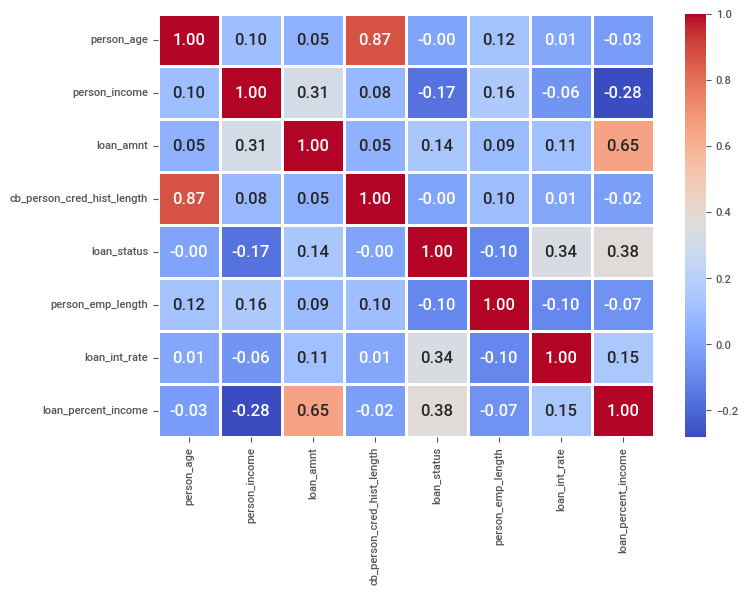

In [ ]:
# 計算數值變數的相關性矩陣
numeric_columns = int_columns + float_columns
correlation_matrix = train_df[numeric_columns].corr()

# 創建相關性熱圖
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 只顯示下三角
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f', 
            linewidths=0.5,
            square=True)
plt.title('數值變數相關性熱圖', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# 找出高相關性的變數對
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # 相關性閾值
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], 
                                   corr_val))

if high_corr_pairs:
    print("\n高相關性變數對 (|相關係數| > 0.7):")
    for var1, var2, corr in high_corr_pairs:
        print(f"{var1} ↔ {var2}: {corr:.3f}")
else:
    print("\n沒有發現高相關性變數對 (|相關係數| > 0.7)")

## 3.3 分類變數與目標變數的關係分析

分析分類變數在不同貸款狀態下的分布模式。

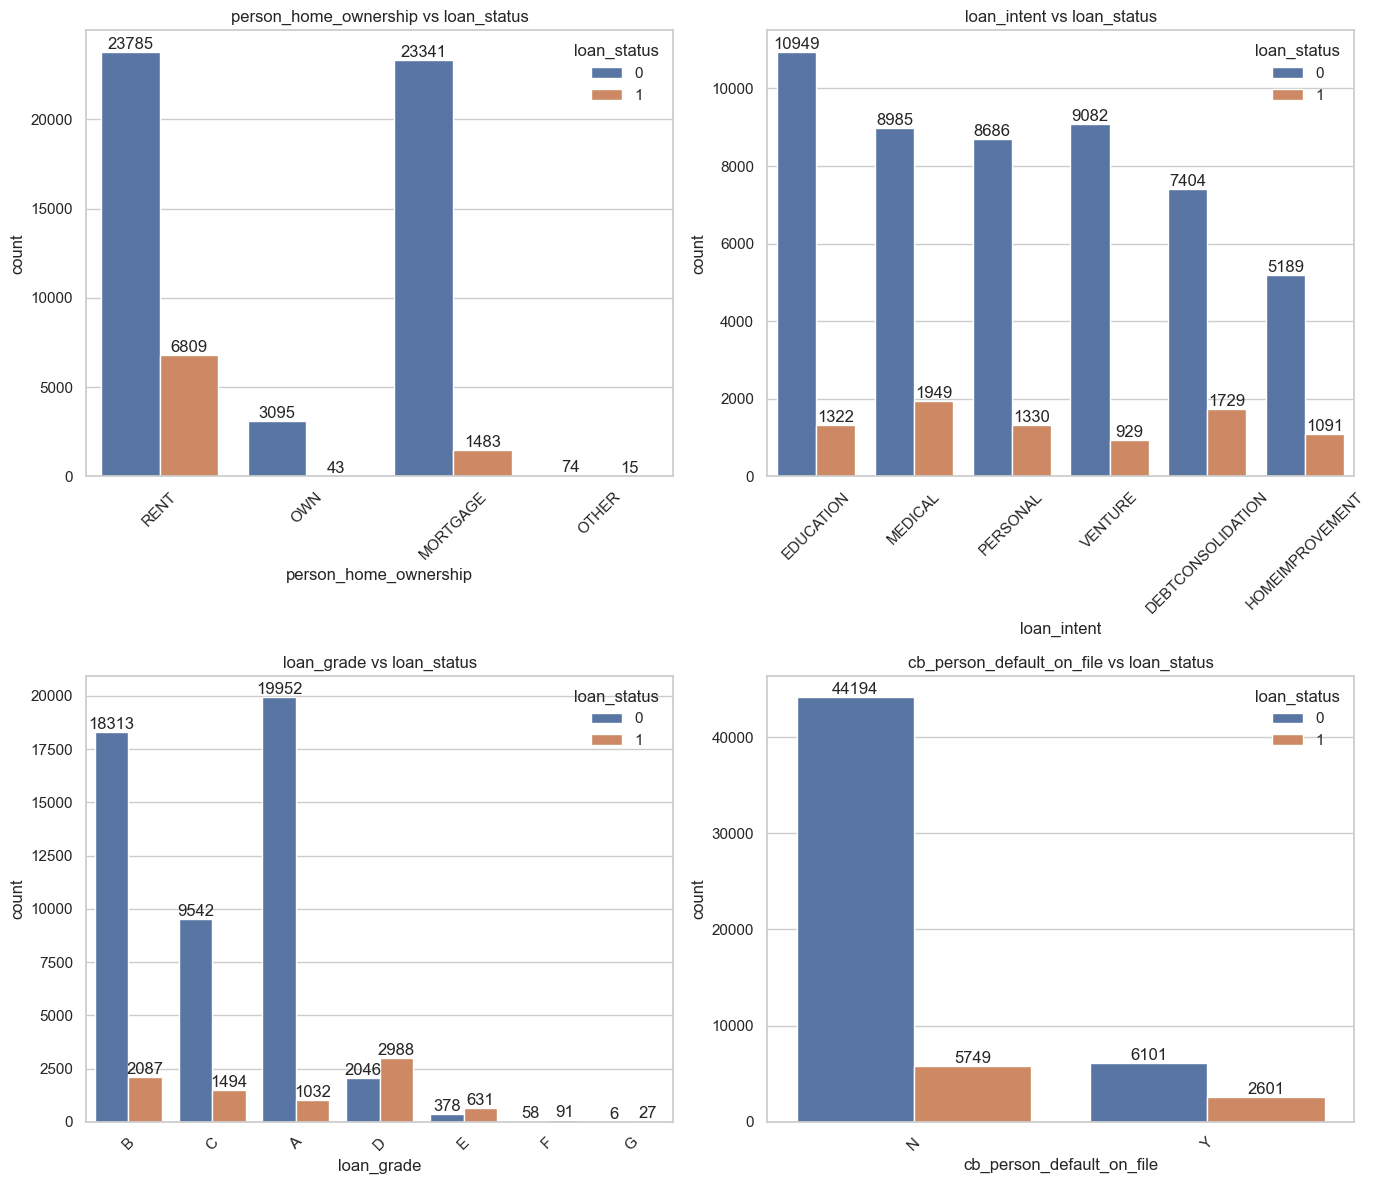

In [ ]:
# 分析分類變數與目標變數的關係
plt.style.use('seaborn-v0_8-whitegrid')

n_cols = 2  
n_rows = (len(object_columns) + n_cols - 1) // n_cols

# 創建子圖
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
fig.suptitle('分類變數與貸款狀態的關係分析', fontsize=20, y=1.02)

# 確保 axes 是二維數組
if n_rows == 1:
    axes = axes.reshape(1, -1)

# 為每個分類變數創建計數圖
for i, column in enumerate(object_columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # 創建計數圖
    sns.countplot(data=train_df, x=column, hue=TARGET, ax=ax, palette='Set2')
    ax.set_title(f'{column} vs {TARGET}', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # 添加數值標籤
    for container in ax.containers:
        ax.bar_label(container, fmt='%d')
    
    # 添加圖例
    ax.legend(title='貸款狀態', labels=['核准', '拒絕'])

# 移除多餘的子圖
for j in range(len(object_columns), n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# 計算並顯示每個分類變數的統計資訊
print("\n分類變數統計摘要:")
print("="*50)
for col in object_columns:
    contingency_table = pd.crosstab(train_df[col], train_df[TARGET], margins=True)
    print(f"\n{col}:")
    print(contingency_table)

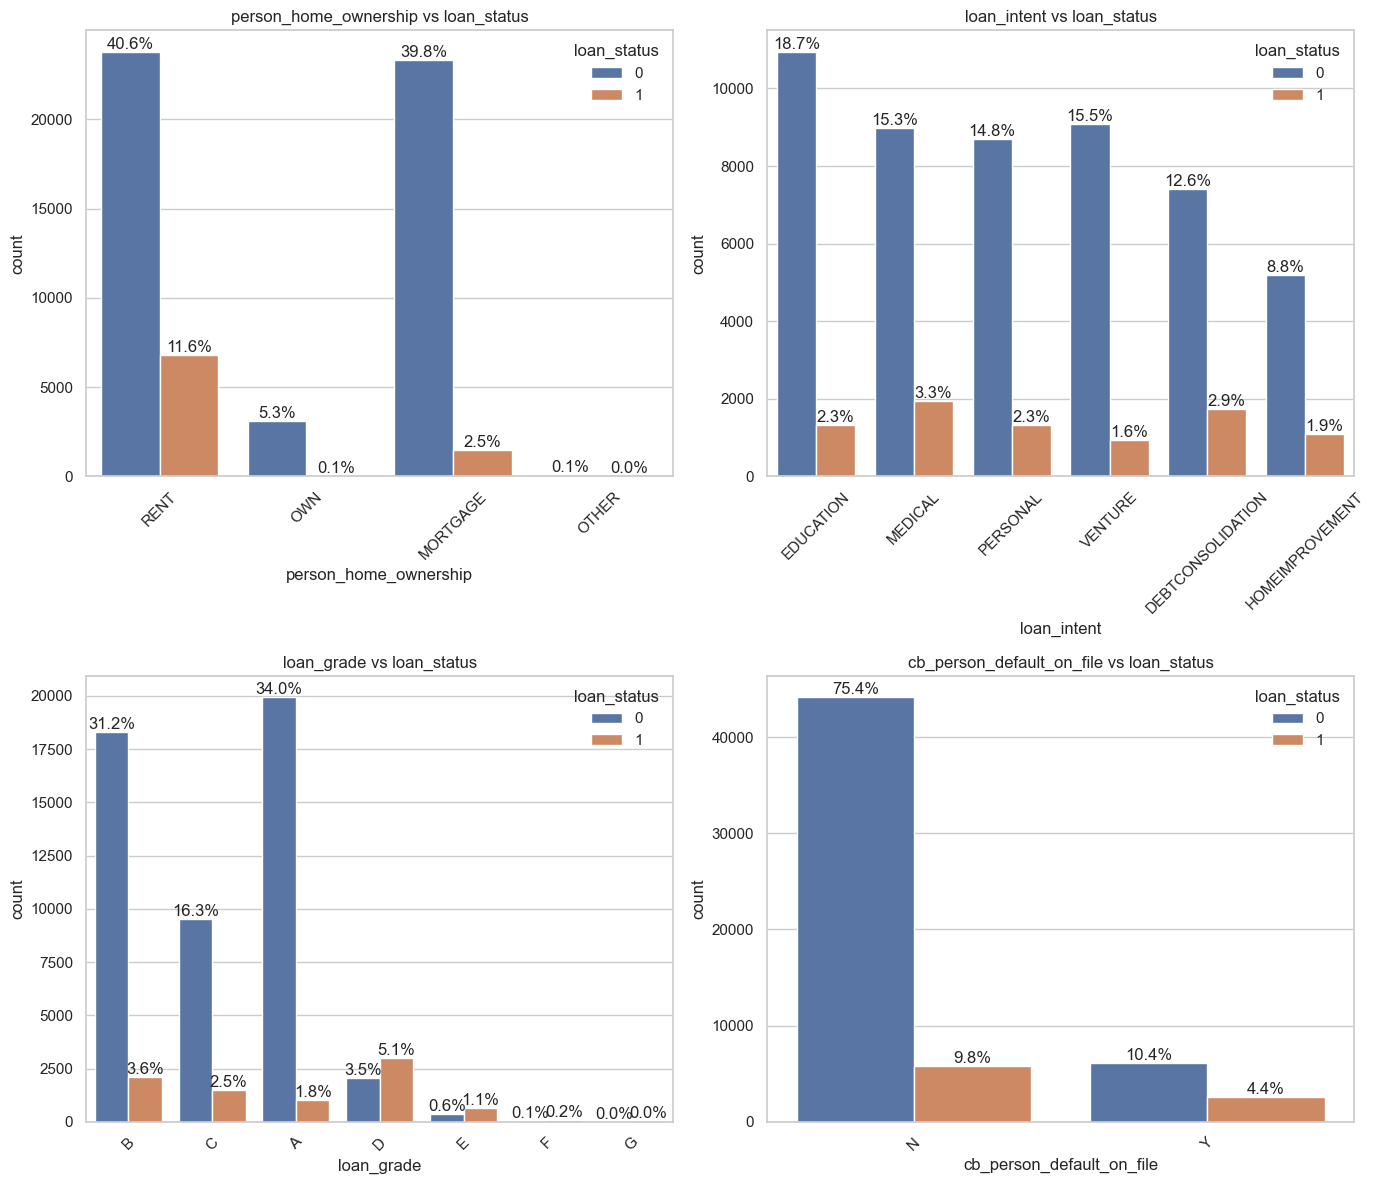

In [ ]:
# 創建百分比堆疊圖，更清楚地顯示比例關係
n_cols = 2  
n_rows = (len(object_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
fig.suptitle('分類變數中各類別的貸款狀態比例分析', fontsize=20, y=1.02)

# 確保 axes 是二維數組
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, column in enumerate(object_columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # 計算百分比
    crosstab = pd.crosstab(train_df[column], train_df[TARGET], normalize='index') * 100
    
    # 創建堆疊條形圖
    crosstab.plot(kind='bar', stacked=True, ax=ax, 
                  color=['lightgreen', 'lightcoral'], alpha=0.8)
    
    ax.set_title(f'{column} - 貸款狀態比例', fontsize=14, fontweight='bold')
    ax.set_xlabel(column)
    ax.set_ylabel('百分比 (%)')
    ax.legend(title='貸款狀態', labels=['核准', '拒絕'])
    ax.tick_params(axis='x', rotation=45)
    
    # 添加百分比標籤
    for p in ax.patches:
        percentage = f'{p.get_height():.1f}%'
        if p.get_height() > 5:  # 只顯示大於5%的標籤
            ax.annotate(percentage, 
                       (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2),
                       ha='center', va='center', fontweight='bold')

# 移除多餘的子圖
for j in range(len(object_columns), n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

## 3.4 數值變數分布分析

### 3.4.1 核准貸款群組的統計描述

In [ ]:
# 核准貸款群組 (loan_status = 0) 的數值變數統計描述
approved_stats = train_df[train_df[TARGET]==0].drop(columns=['id',TARGET]).describe().round(2).T

print("核准貸款群組 - 數值變數統計描述")
print("="*60)
print(approved_stats)

# 同時顯示拒絕貸款群組的統計描述以便比較
rejected_stats = train_df[train_df[TARGET]==1].drop(columns=['id',TARGET]).describe().round(2).T

print("\n\n拒絕貸款群組 - 數值變數統計描述")
print("="*60)
print(rejected_stats)

# 計算兩群組間的差異
print("\n\n兩群組平均值差異 (核准 - 拒絕)")
print("="*60)
mean_diff = approved_stats['mean'] - rejected_stats['mean']
print(mean_diff.round(2))

,count,mean,std,min,25%,50%,75%,max
person_age,50295.0,27.55,5.98,20.00,23.00,26.00,30.00,123.00
person_income,50295.0,66672.87,39314.38,4200.00,45000.00,60000.00,80000.00,1900000.00
person_emp_length,50295.0,4.86,3.95,0.00,2.00,4.00,7.00,123.00
loan_amnt,50295.0,8888.88,5328.36,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,50295.0,10.26,2.83,5.42,7.51,10.39,12.42,22.11
loan_percent_income,50295.0,0.15,0.08,0.00,0.08,0.13,0.20,0.63
cb_person_cred_hist_length,50295.0,5.82,4.00,2.00,3.00,4.00,8.00,30.00


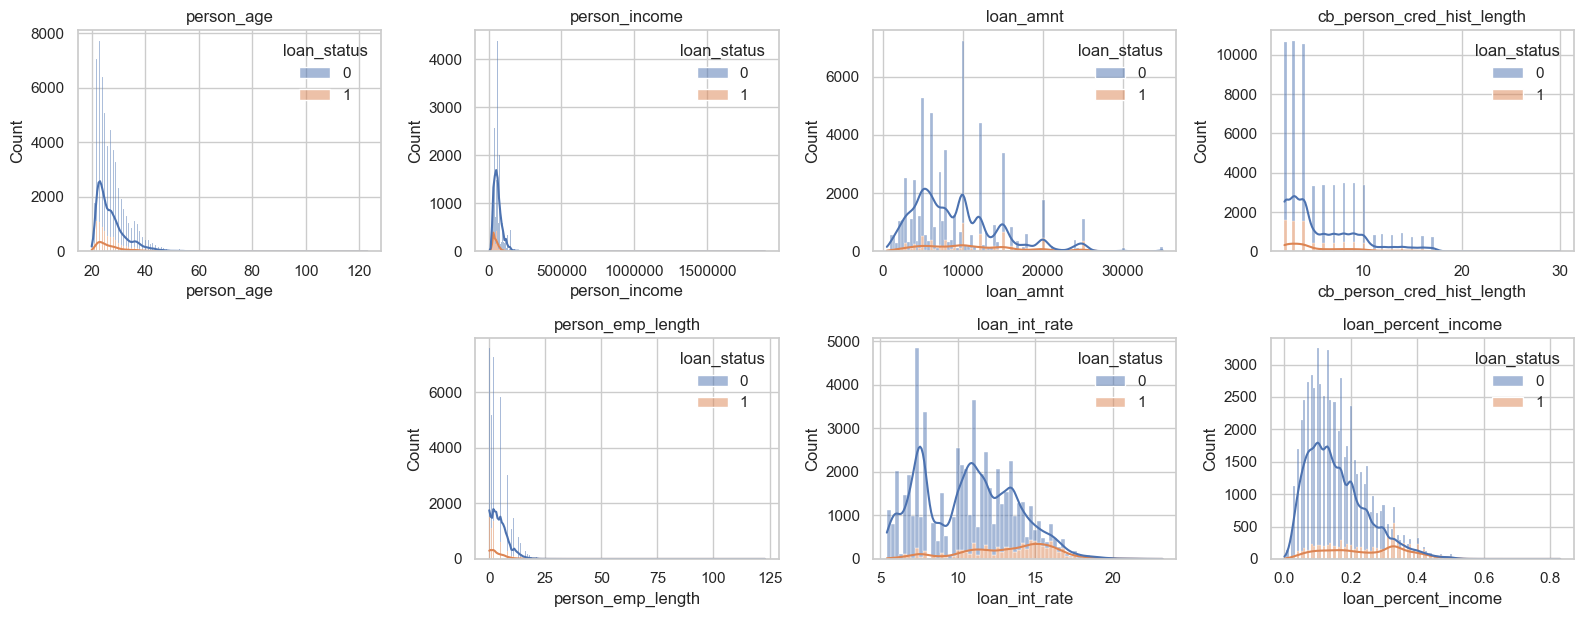

In [ ]:
# 數值變數分布分析 - 按貸款狀態分組
numeric_cols_for_plot = [col for col in int_columns + float_columns if col != TARGET]

plt.figure(figsize=(20, 16))
for i, col in enumerate(numeric_cols_for_plot, 1):
    plt.subplot(4, 4, i)
    
    # 創建分組直方圖
    sns.histplot(data=train_df, x=col, hue=TARGET, 
                kde=True, alpha=0.7, stat='density',
                palette=['lightgreen', 'lightcoral'])
    
    plt.title(f'{col} 分布比較', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('密度')
    plt.legend(labels=['核准', '拒絕'], title='貸款狀態')

plt.suptitle('數值變數在不同貸款狀態下的分布比較', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

# 顯示基本統計資訊
print("數值變數基本統計比較:")
print("="*50)
for col in numeric_cols_for_plot:
    approved_mean = train_df[train_df[TARGET]==0][col].mean()
    rejected_mean = train_df[train_df[TARGET]==1][col].mean()
    print(f"{col:20} - 核准平均: {approved_mean:8.2f}, 拒絕平均: {rejected_mean:8.2f}, 差異: {approved_mean-rejected_mean:8.2f}")

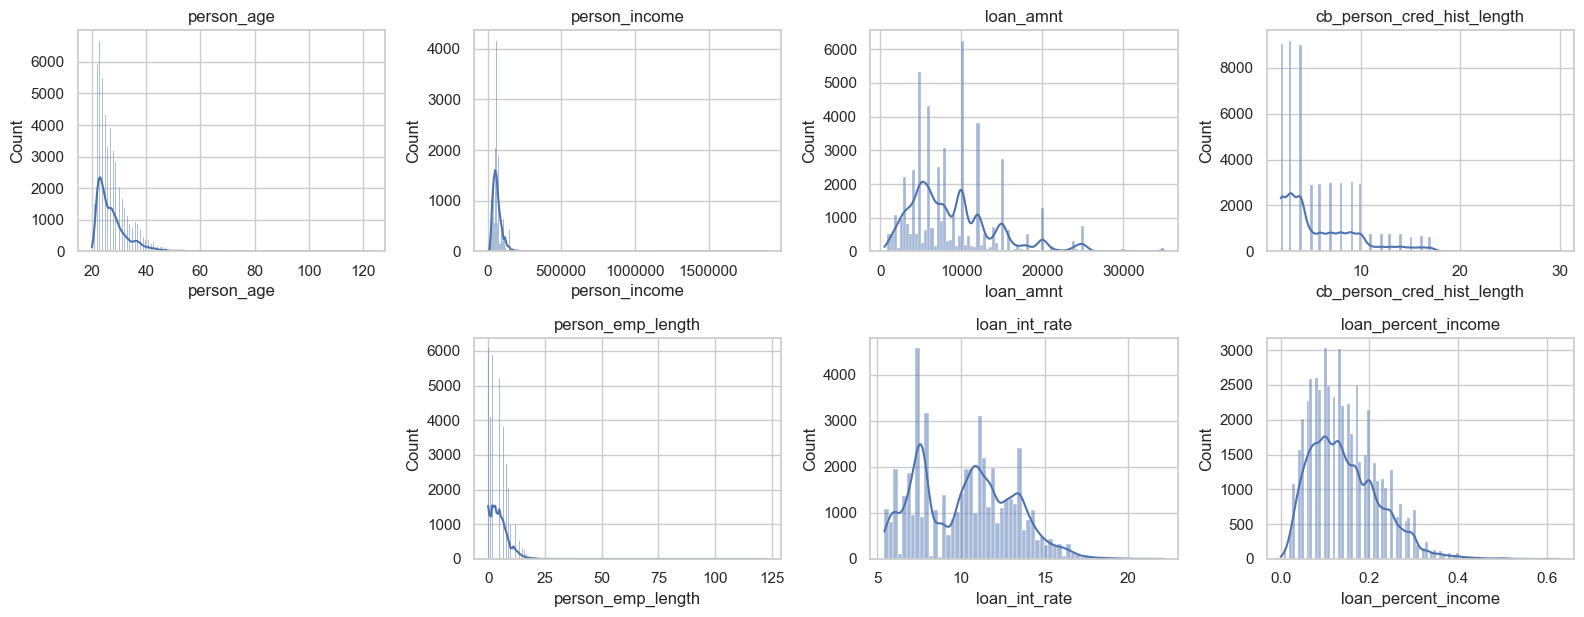

In [ ]:
# 核准貸款群組的數值變數分布
plt.figure(figsize=(20, 16))
for i, col in enumerate(numeric_cols_for_plot, 1):
    plt.subplot(4, 4, i)
    
    # 只顯示核准貸款的分布
    data_approved = train_df[train_df[TARGET]==0][col]
    sns.histplot(data_approved, kde=True, color='lightgreen', alpha=0.7)
    
    plt.title(f'{col} (核准貸款)', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('頻數')
    
    # 添加統計資訊
    mean_val = data_approved.mean()
    median_val = data_approved.median()
    plt.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'平均: {mean_val:.2f}')
    plt.axvline(median_val, color='blue', linestyle='--', alpha=0.8, label=f'中位數: {median_val:.2f}')
    plt.legend()

plt.suptitle('核准貸款群組 - 數值變數分布分析', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

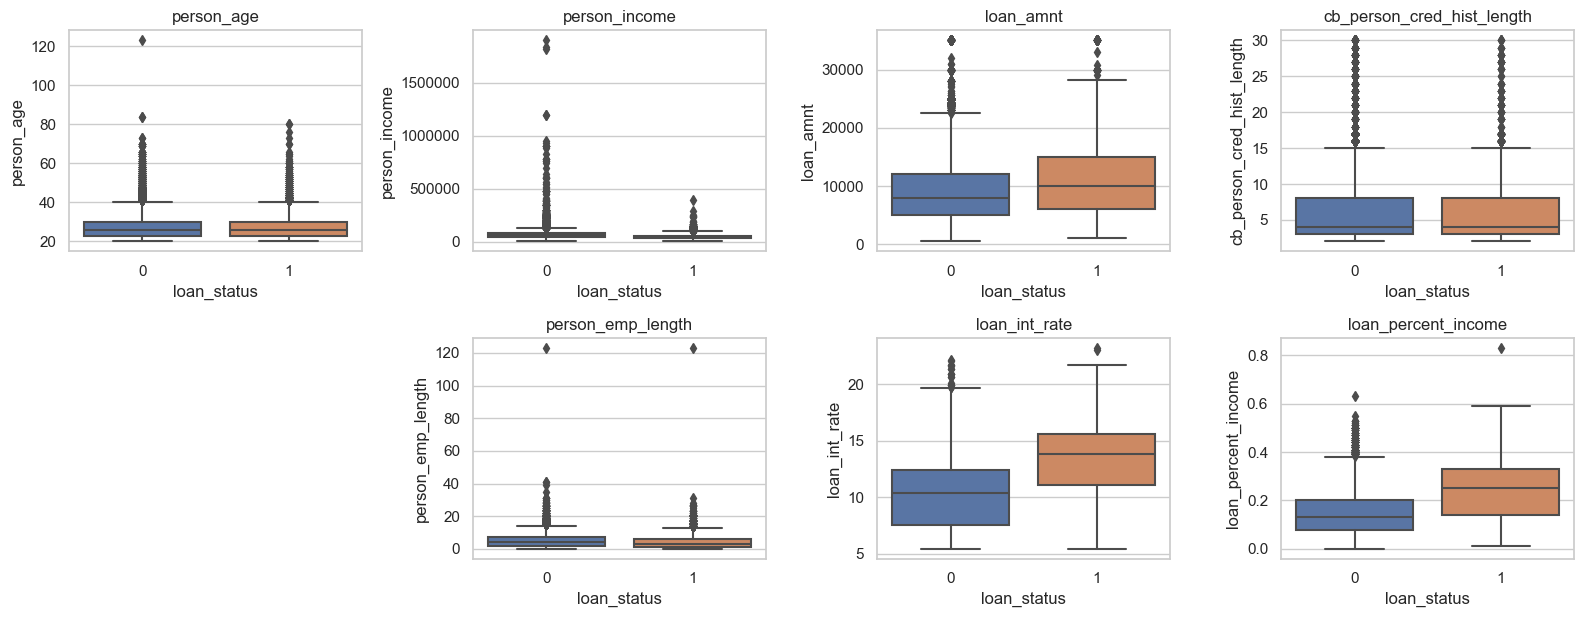

In [ ]:
# 使用箱型圖比較不同貸款狀態下的數值變數分布
plt.figure(figsize=(20, 16))
for i, col in enumerate(numeric_cols_for_plot, 1):
    plt.subplot(4, 4, i)
    
    # 創建箱型圖
    sns.boxplot(data=train_df, x=TARGET, y=col, palette=['lightgreen', 'lightcoral'])
    
    plt.title(f'{col} 箱型圖比較', fontweight='bold')
    plt.xlabel('貸款狀態')
    plt.ylabel(col)
    
    # 設置 x 軸標籤
    plt.xticks([0, 1], ['核准', '拒絕'])

plt.suptitle('數值變數箱型圖 - 貸款狀態比較', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

# 識別可能的異常值
print("異常值檢測 (使用 IQR 方法):")
print("="*50)
for col in numeric_cols_for_plot:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(train_df)) * 100
    
    print(f"{col:20} - 異常值數量: {len(outliers):5} ({outlier_percentage:5.2f}%)")

### 3.4.2 按貸款等級分析分類變數表現

###### see different loan grade cate col performance

Rank: B



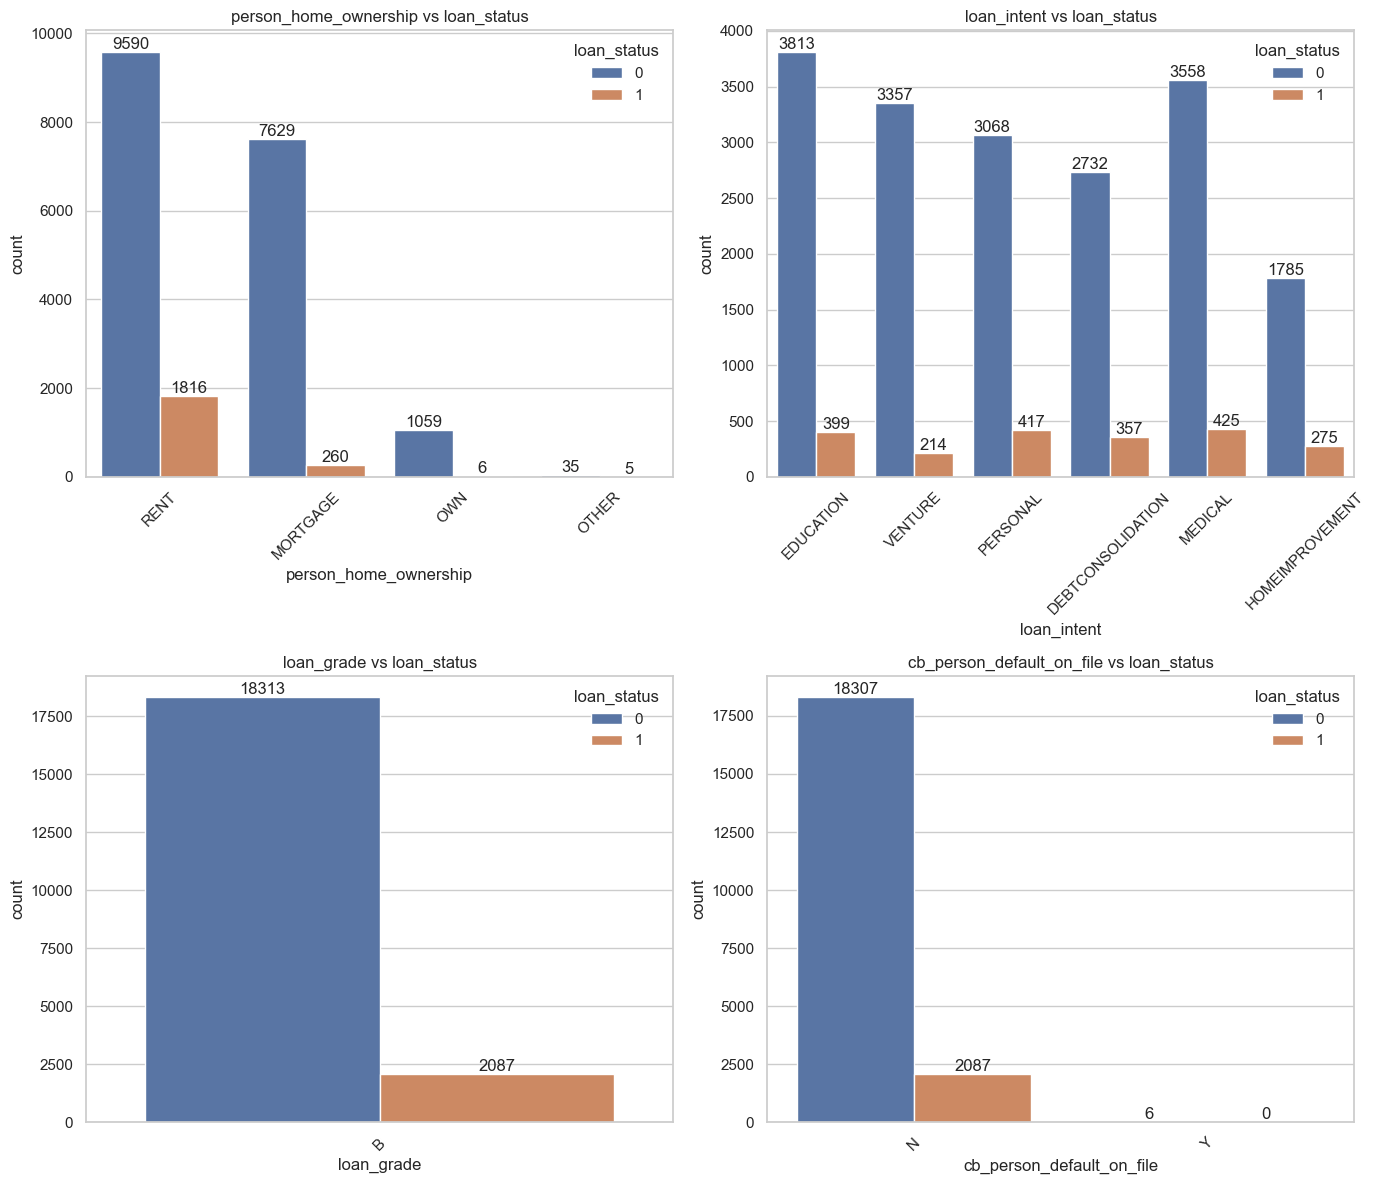




Rank: C



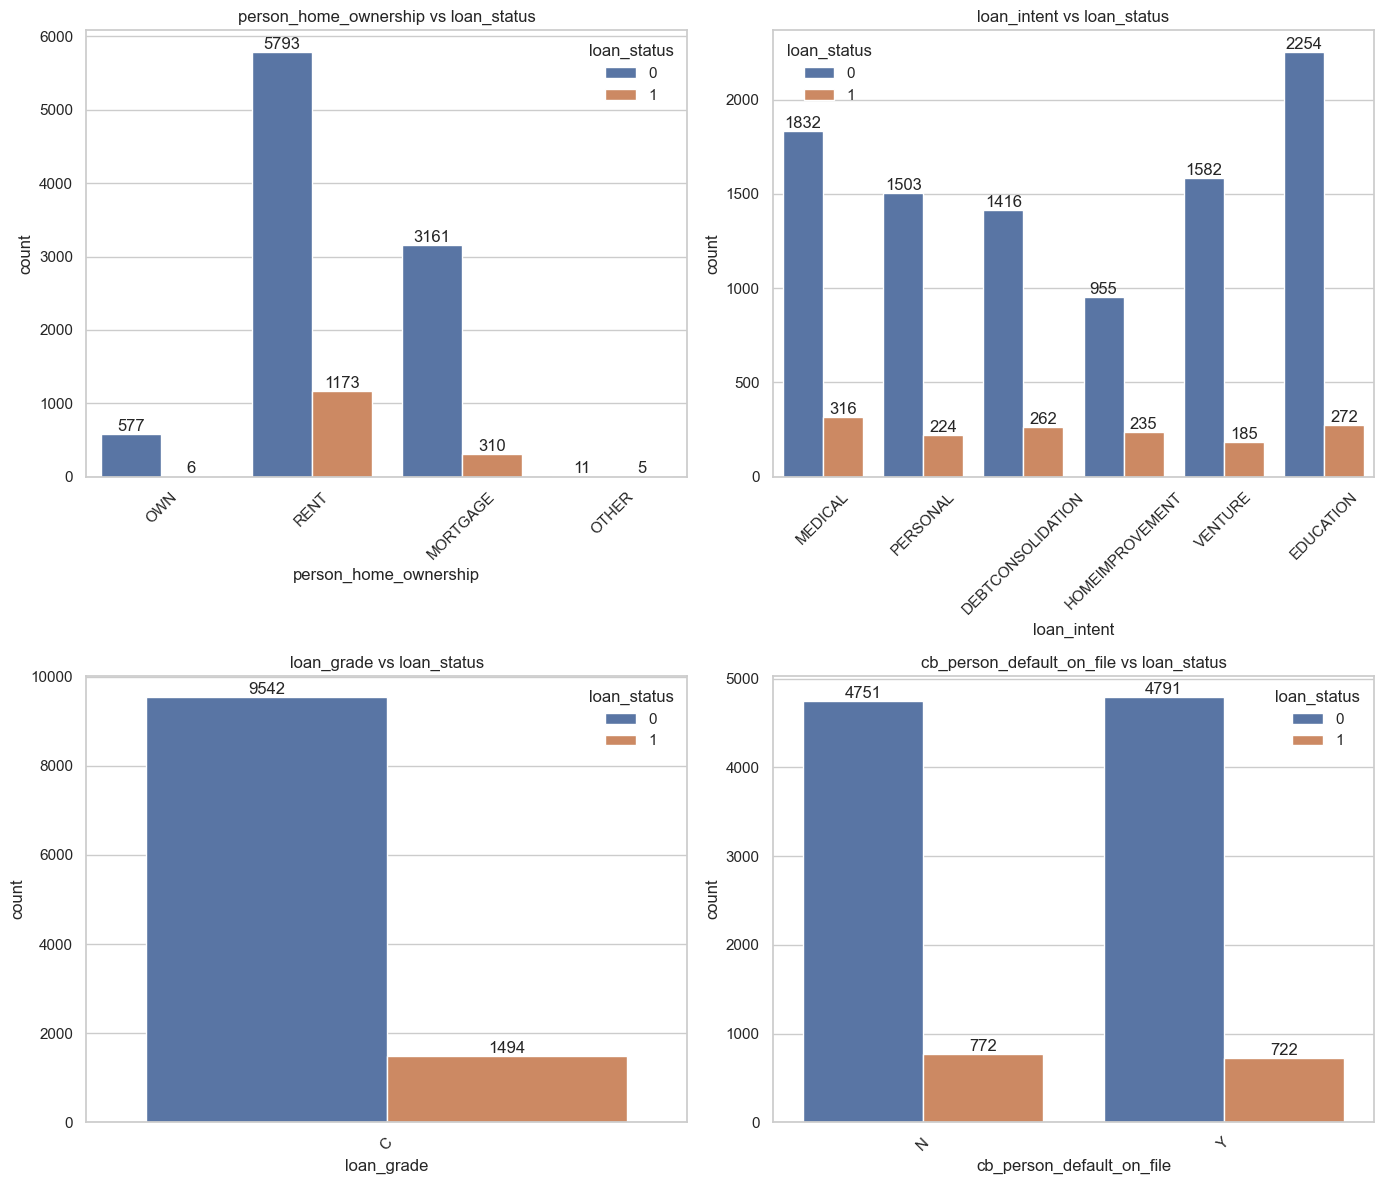




Rank: A



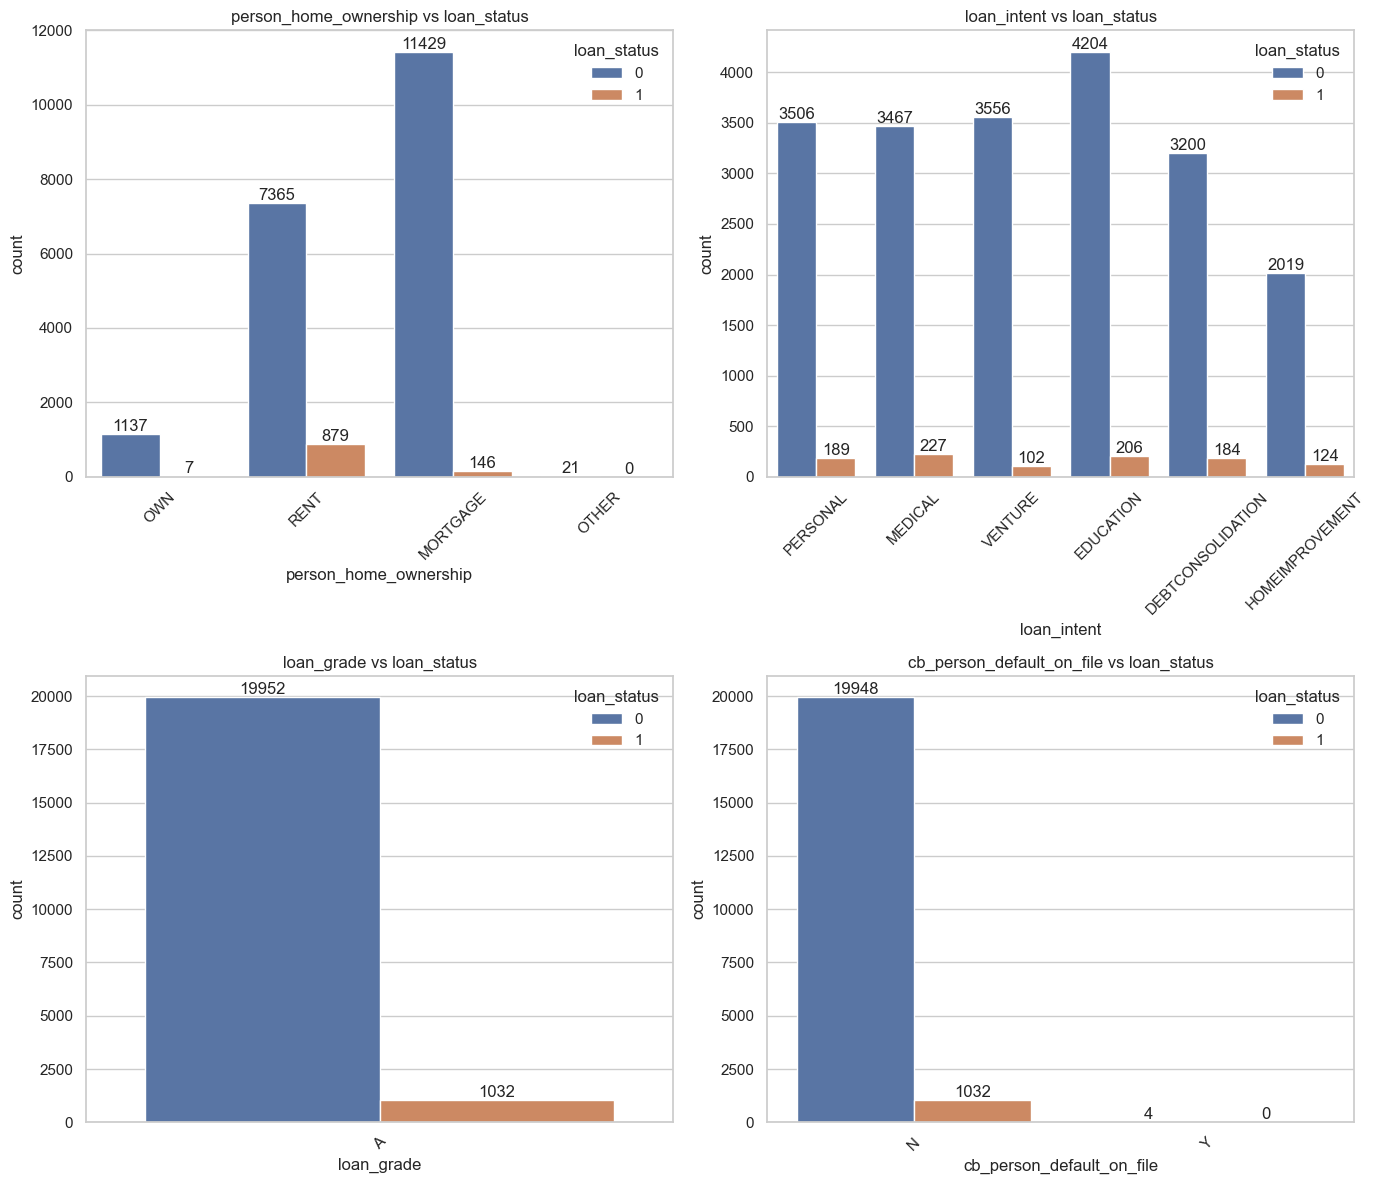




Rank: D



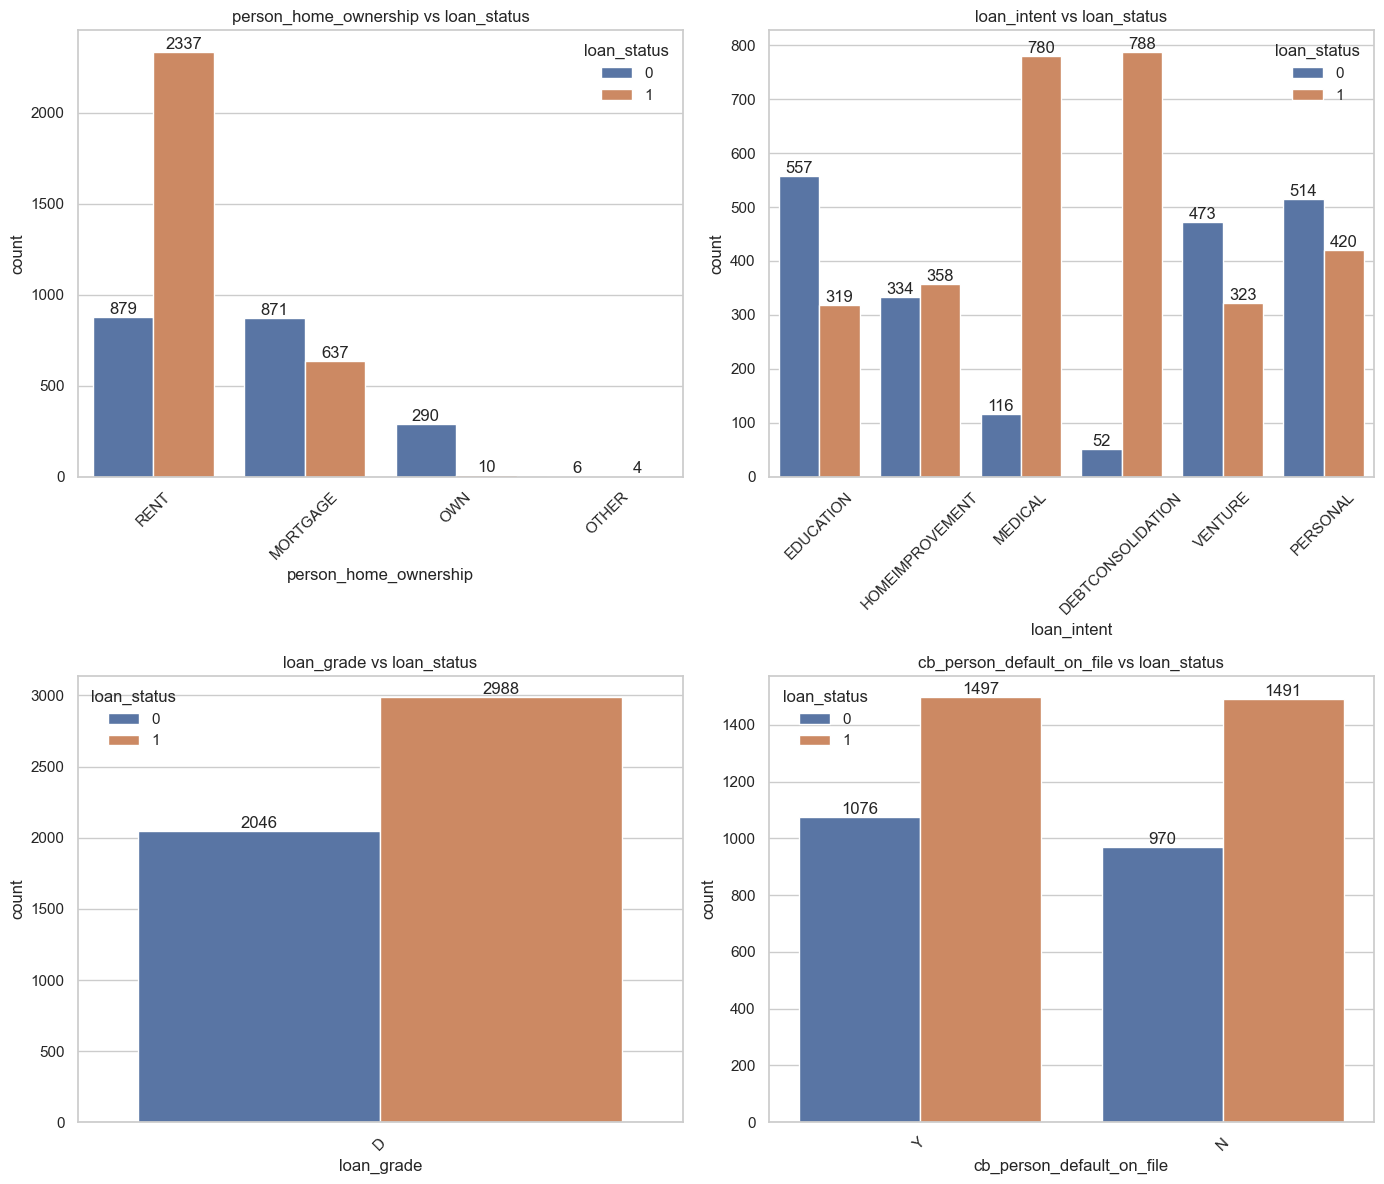




Rank: E



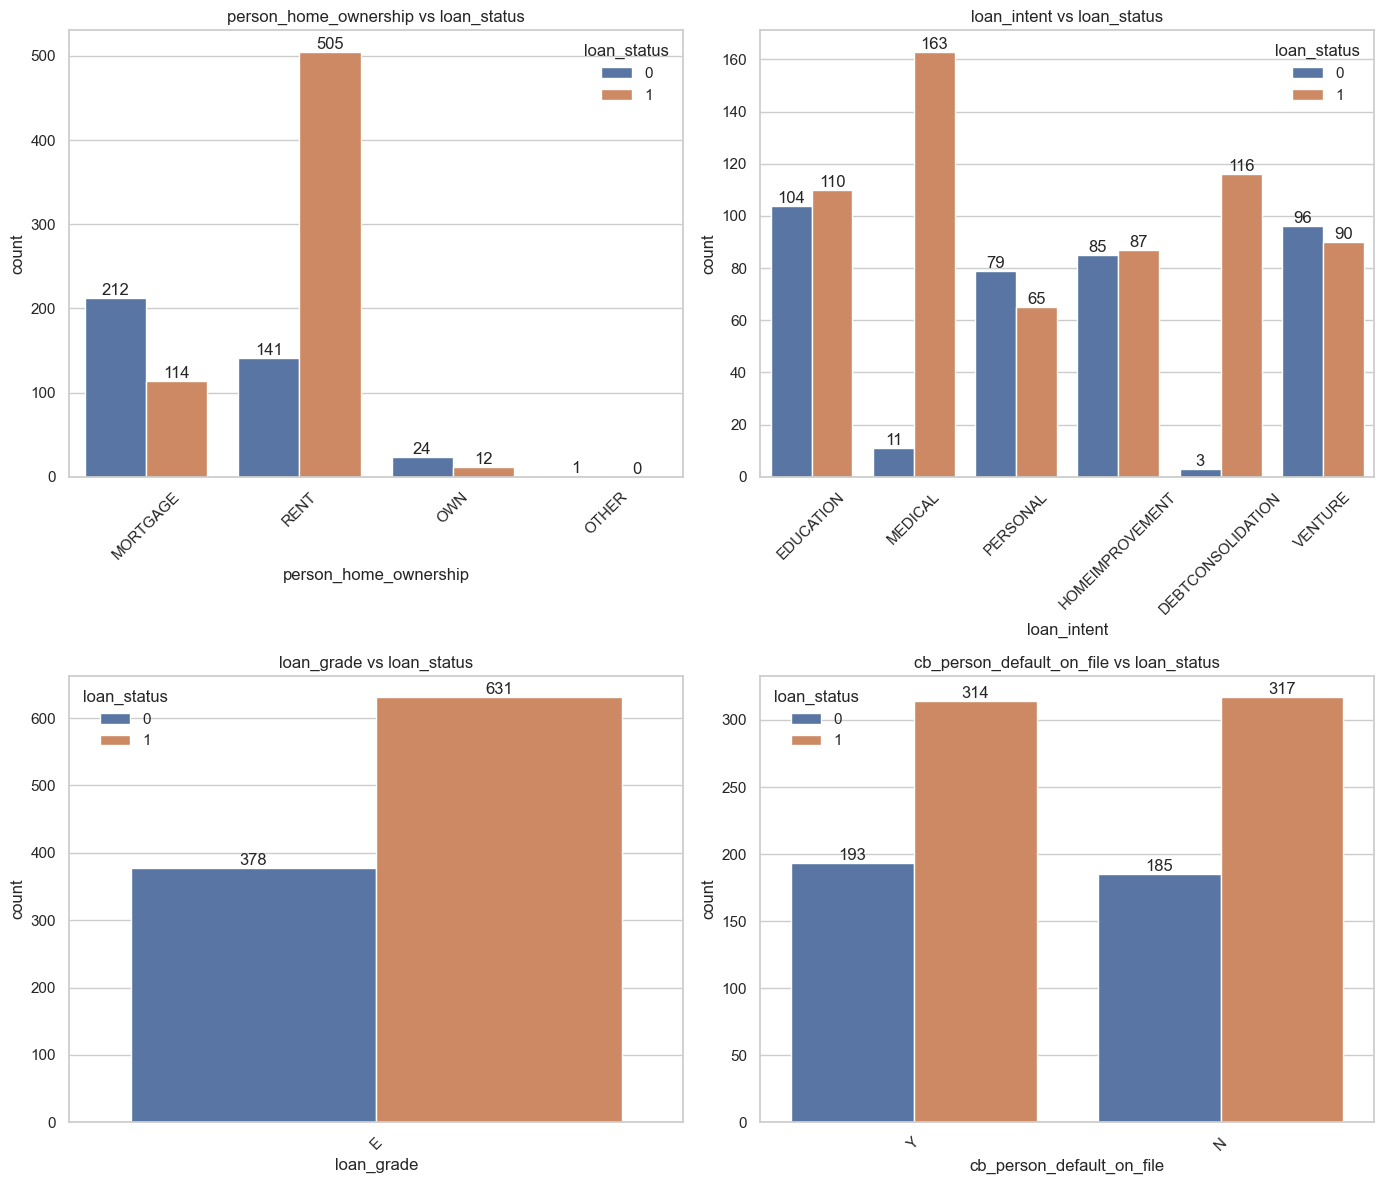




Rank: F



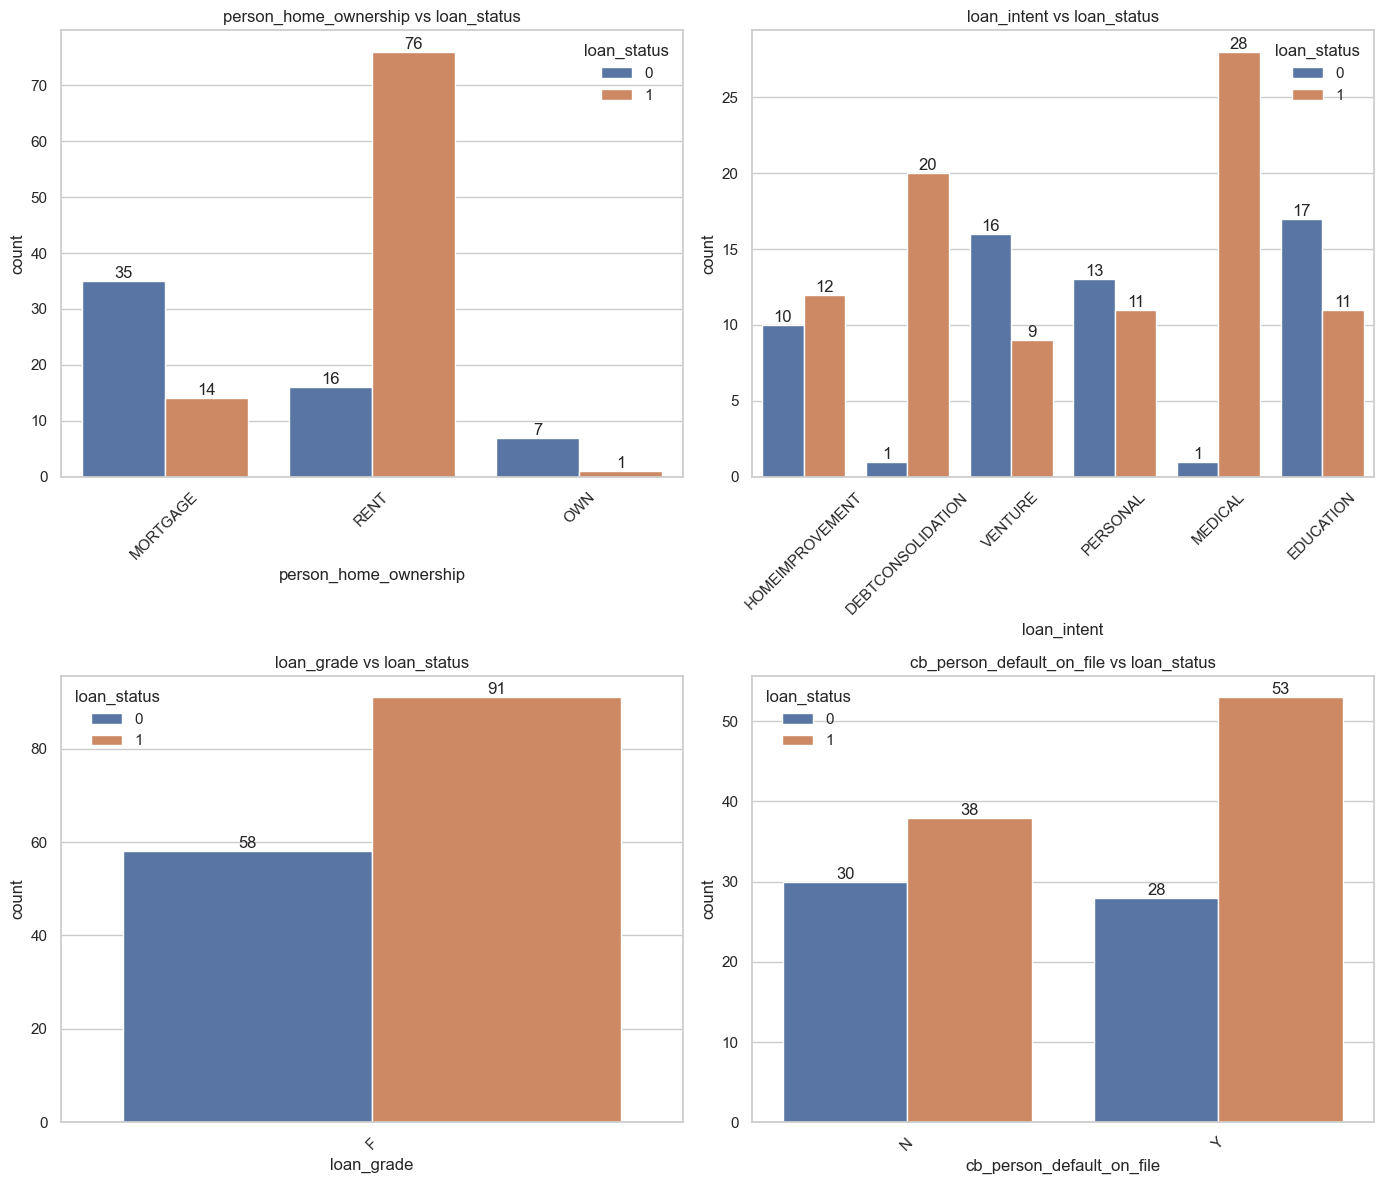




Rank: G



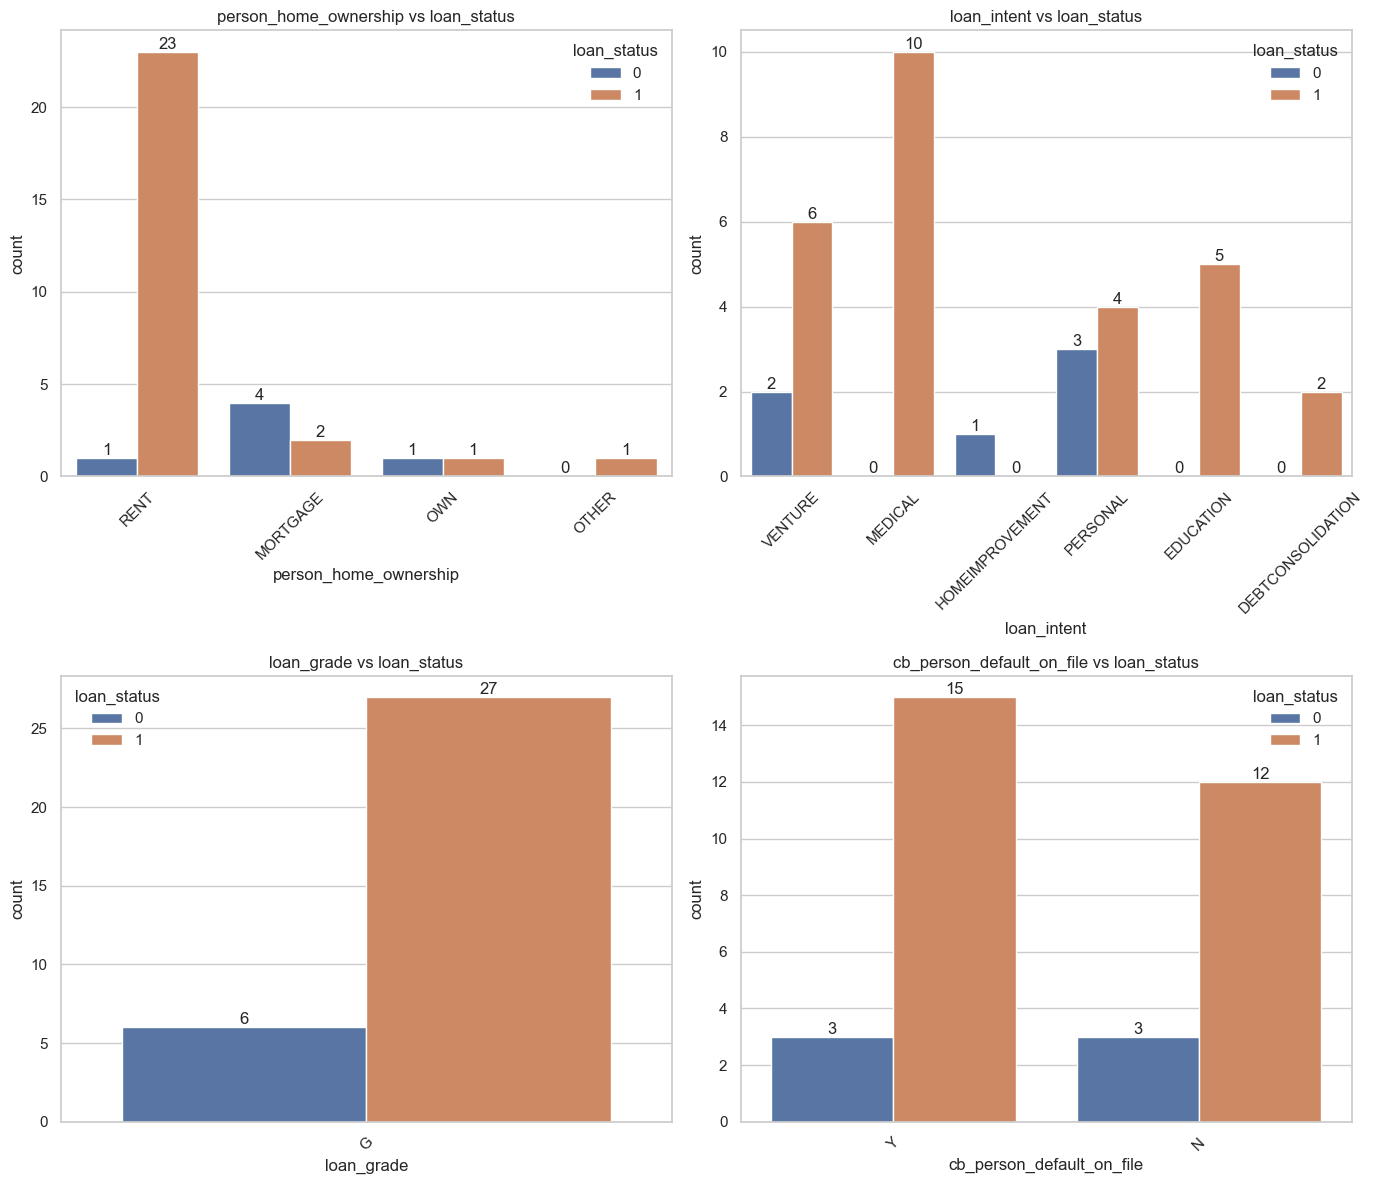

In [ ]:
# 按貸款等級分析分類變數的表現
unique_grades = sorted(train_df['loan_grade'].unique())
print(f"貸款等級: {unique_grades}")

plt.style.use('seaborn-v0_8-whitegrid')

for grade in unique_grades:
    grade_data = train_df[train_df['loan_grade'] == grade]
    
    # 檢查該等級是否有足夠的數據
    if len(grade_data) < 10:
        print(f"等級 {grade} 的數據量太少，跳過分析")
        continue
    
    print(f"\n{'='*60}")
    print(f"貸款等級: {grade}")
    print(f"總數量: {len(grade_data)}")
    print(f"核准率: {(grade_data[TARGET]==0).mean()*100:.1f}%")
    print(f"{'='*60}")
    
    n_cols = 2  
    n_rows = (len(object_columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    fig.suptitle(f'貸款等級 {grade} - 分類變數分析', fontsize=18, y=1.02)
    
    # 確保 axes 是二維數組
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for i, column in enumerate(object_columns):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # 創建計數圖
        sns.countplot(data=grade_data, x=column, hue=TARGET, ax=ax, palette='Set2')
        ax.set_title(f'{column} vs {TARGET}', fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        
        # 添加數值標籤
        for container in ax.containers:
            ax.bar_label(container, fmt='%d')
        
        ax.legend(title='貸款狀態', labels=['核准', '拒絕'])

    # 移除多餘的子圖
    for j in range(len(object_columns), n_rows * n_cols):
        row = j // n_cols
        col = j % n_cols
        fig.delaxes(axes[row, col])
                  
    plt.tight_layout()
    plt.show()
    
    # 顯示該等級的統計摘要
    for col in object_columns:
        if col != 'loan_grade':  # 跳過 loan_grade 本身
            crosstab = pd.crosstab(grade_data[col], grade_data[TARGET], margins=True)
            if len(crosstab) > 1:  # 確保有變化
                print(f"\n{col} 分布:")
                print(crosstab)

### 3.4.3 拒絕貸款群組的詳細分析

In [ ]:
# 拒絕貸款群組 (loan_status = 1) 的數值變數統計描述
rejected_detailed = train_df[train_df[TARGET]==1].drop(columns=['id',TARGET]).describe().round(2).T

print("拒絕貸款群組 - 詳細統計描述")
print("="*60)
print(rejected_detailed)

# 比較核准和拒絕群組的關鍵差異
print("\n關鍵差異分析:")
print("="*40)
approved_data = train_df[train_df[TARGET]==0].drop(columns=['id',TARGET])
rejected_data = train_df[train_df[TARGET]==1].drop(columns=['id',TARGET])

for col in approved_data.columns:
    approved_mean = approved_data[col].mean()
    rejected_mean = rejected_data[col].mean()
    difference = rejected_mean - approved_mean
    pct_diff = (difference / approved_mean) * 100 if approved_mean != 0 else 0
    
    print(f"{col:20} | 核准: {approved_mean:8.2f} | 拒絕: {rejected_mean:8.2f} | 差異: {difference:8.2f} ({pct_diff:+6.1f}%)")

,count,mean,std,min,25%,50%,75%,max
person_age,8350.0,27.53,6.34,20.00,23.00,26.00,30.00,80.00
person_income,8350.0,48224.66,22435.67,9600.00,32000.00,44000.00,59000.00,397800.00
person_emp_length,8350.0,3.73,3.89,0.00,1.00,3.00,6.00,123.00
loan_amnt,8350.0,11197.27,6468.21,1000.00,6000.00,10000.00,15000.00,35000.00
loan_int_rate,8350.0,13.20,3.02,5.42,11.11,13.79,15.58,23.22
loan_percent_income,8350.0,0.24,0.12,0.01,0.14,0.25,0.33,0.83
cb_person_cred_hist_length,8350.0,5.78,4.19,2.00,3.00,4.00,8.00,30.00


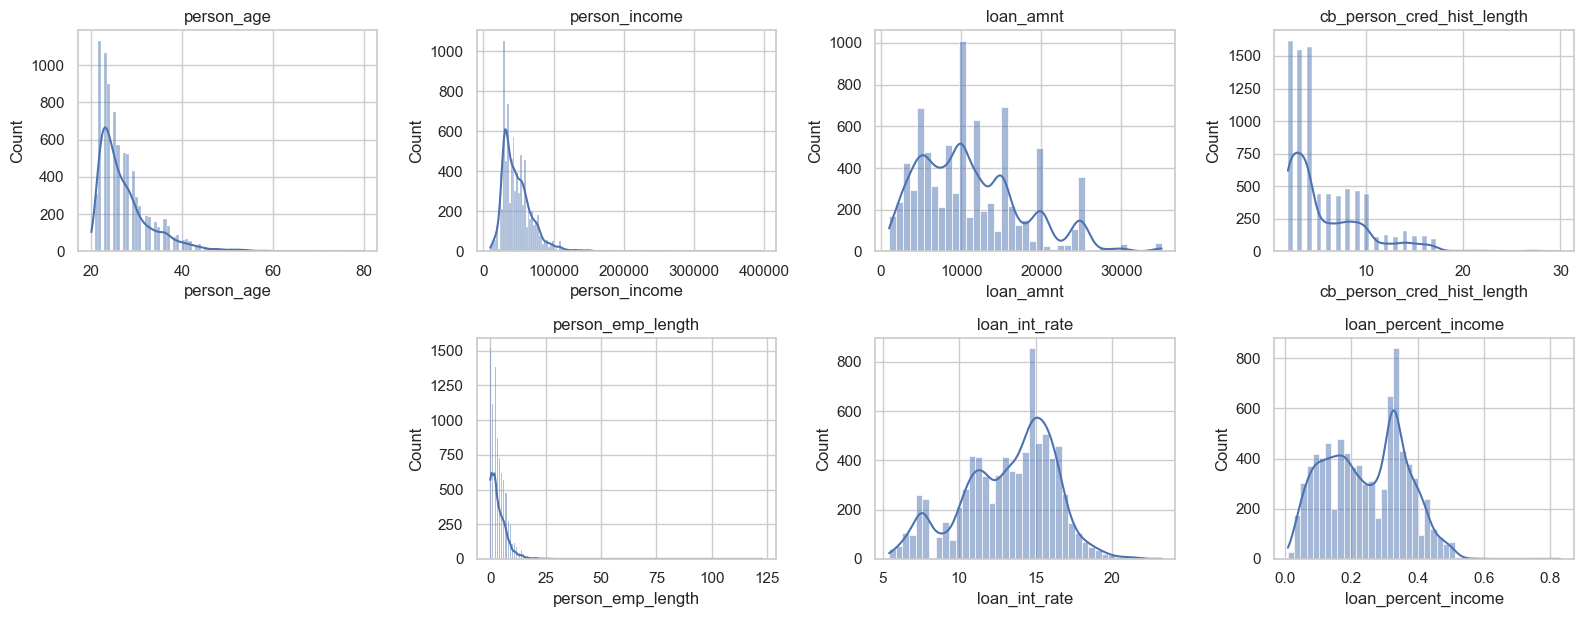

In [ ]:
# 拒絕貸款群組的數值變數分布
plt.figure(figsize=(20, 16))
for i, col in enumerate(numeric_cols_for_plot, 1):
    plt.subplot(4, 4, i)
    
    # 只顯示拒絕貸款的分布
    data_rejected = train_df[train_df[TARGET]==1][col]
    sns.histplot(data_rejected, kde=True, color='lightcoral', alpha=0.7)
    
    plt.title(f'{col} (拒絕貸款)', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('頻數')
    
    # 添加統計資訊
    mean_val = data_rejected.mean()
    median_val = data_rejected.median()
    plt.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'平均: {mean_val:.2f}')
    plt.axvline(median_val, color='blue', linestyle='--', alpha=0.8, label=f'中位數: {median_val:.2f}')
    plt.legend()

plt.suptitle('拒絕貸款群組 - 數值變數分布分析', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

# 4. 數據預處理 {#數據預處理}

## 4.1 基準模型 - 使用標籤編碼

首先建立一個簡單的基準模型，使用標籤編碼處理分類變數，以評估初始性能。

In [ ]:
# 基準模型：使用標籤編碼處理分類變數
from sklearn.preprocessing import LabelEncoder

# 複製原始數據
baseline_df = train_df.copy()

# 為每個分類變數創建標籤編碼器
label_encoders = {}
encoding_mappings = {}

print("標籤編碼處理:")
print("="*40)

for col in object_columns:
    # 初始化標籤編碼器
    le = LabelEncoder()
    
    # 擬合並轉換數據
    baseline_df[col] = le.fit_transform(baseline_df[col])
    
    # 儲存編碼器和映射關係
    label_encoders[col] = le
    encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    print(f"{col:25} : {encoding_mappings[col]}")

print(f"\n處理後的數據形狀: {baseline_df.shape}")
print(f"數據類型檢查:")
print(baseline_df.dtypes)

In [ ]:
# 基準模型訓練 - 只使用數值特徵
print("基準模型訓練 (僅數值特徵)")
print("="*50)

# 準備特徵和目標變數 (僅使用數值特徵)
feature_cols = [col for col in int_columns + float_columns if col != TARGET]
X_baseline = train_df[feature_cols]
y_baseline = train_df[TARGET]

print(f"使用特徵: {feature_cols}")
print(f"特徵數量: {len(feature_cols)}")

# 分割數據
X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(
    X_baseline, y_baseline, test_size=0.3, random_state=42, stratify=y_baseline
)

print(f"訓練集大小: {X_baseline_train.shape}")
print(f"測試集大小: {X_baseline_test.shape}")

# 訓練 LightGBM 基準模型
print("\n訓練 LightGBM 模型...")
lgbm_baseline = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgbm_baseline.fit(X_baseline_train, y_baseline_train)

print("基準模型訓練完成！")

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268


LGBMClassifier()

In [ ]:
# 基準模型評估
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="模型"):
    """評估模型性能的函數"""
    
    # 訓練集預測
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    
    # 測試集預測
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # 計算評估指標
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'auc': roc_auc_score(y_train, y_train_proba),
        'f1': f1_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred)
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'auc': roc_auc_score(y_test, y_test_proba),
        'f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred)
    }
    
    # 顯示結果
    print(f"\n{model_name} 評估結果")
    print("="*60)
    print(f"{'指標':<15} {'訓練集':<12} {'測試集':<12} {'差異':<12}")
    print("-"*60)
    
    for metric in train_metrics.keys():
        train_val = train_metrics[metric]
        test_val = test_metrics[metric]
        diff = train_val - test_val
        print(f"{metric:<15} {train_val:<12.4f} {test_val:<12.4f} {diff:<+12.4f}")
    
    # 混淆矩陣
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    print(f"\n訓練集混淆矩陣:")
    print(train_cm)
    print(f"\n測試集混淆矩陣:")
    print(test_cm)
    
    return train_metrics, test_metrics, (train_cm, test_cm)

# 評估基準模型
baseline_train_metrics, baseline_test_metrics, baseline_cm = evaluate_model(
    lgbm_baseline, X_baseline_train, y_baseline_train, 
    X_baseline_test, y_baseline_test, "基準模型 (僅數值特徵)"
)

Train dataset :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     35169
           1       0.83      0.67      0.74      5882

    accuracy                           0.93     41051
   macro avg       0.89      0.83      0.85     41051
weighted avg       0.93      0.93      0.93     41051

Confusion matrix :
 [[34376   793]
 [ 1922  3960]]

Accuracy : 0.9338627560838957
AUC score : 0.9557057248678744
F1-score : 0.7447108603667136
Precision score : 0.8331580054702293
Recall score : 0.6732403944236655


Test dataset :
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     15126
           1       0.77      0.62      0.69      2468

    accuracy                           0.92     17594
   macro avg       0.85      0.80      0.82     17594
weighted avg       0.92      0.92      0.92     17594

Confusion matrix :
 [[14656   470]
 [  928  1540]]

Accuracy : 0.9205410935546209
AUC score : 0.796

## 4.2 高級預處理 - 使用自定義預處理器

現在使用自定義的預處理器進行更複雜的特徵工程，包括獨熱編碼等。

In [ ]:
# 顯示變數分類摘要以供預處理參考
print("變數分類摘要 (供預處理參考)")
print("="*50)
print(f"整數變數: {int_columns}")
print(f"浮點數變數: {float_columns}")
print(f"分類變數: {object_columns}")
print(f"\n總計: {len(int_columns)} 個整數, {len(float_columns)} 個浮點數, {len(object_columns)} 個分類變數")

int_columns：['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_status']
float_columns：['person_emp_length', 'loan_int_rate', 'loan_percent_income']
object_columns：['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [ ]:
# 使用自定義預處理器進行特徵工程
print("使用自定義預處理器進行高級特徵工程")
print("="*60)

# 初始化預處理器
preprocessor = Preprocessor()

# 指定需要進行獨熱編碼的分類變數
one_hot_columns = ['loan_grade', 'person_home_ownership', 'loan_intent', 'cb_person_default_on_file']

print(f"將對以下變數進行獨熱編碼: {one_hot_columns}")

# 執行預處理
processed_df, mapping_df = preprocessor.preprocess(
    df=train_df,
    one_hot_columns=one_hot_columns
)

print(f"\n預處理完成!")
print(f"原始數據形狀: {train_df.shape}")
print(f"處理後數據形狀: {processed_df.shape}")
print(f"新增特徵數量: {processed_df.shape[1] - train_df.shape[1]}")

# 顯示處理後的欄位
print(f"\n處理後的欄位 ({len(processed_df.columns)} 個):")
for i, col in enumerate(processed_df.columns):
    if i % 5 == 0:
        print()
    print(f"{col:25}", end=" ")
print()

In [ ]:
# 檢查處理後數據的類型分布
print("處理後數據類型分布:")
print("="*30)
dtype_counts = processed_df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{str(dtype):10} : {count:3} 個欄位")

# 檢查是否有缺失值
missing_check = processed_df.isnull().sum().sum()
print(f"\n缺失值檢查: {'無缺失值' if missing_check == 0 else f'共 {missing_check} 個缺失值'}")

# 記憶體使用量
memory_usage = processed_df.memory_usage(deep=True).sum() / 1024**2
print(f"記憶體使用量: {memory_usage:.2f} MB")

id                                  int64
person_age                          int64
person_income                       int64
person_emp_length                 float64
loan_amnt                           int64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length          int64
loan_status                         int64
loan_grade_A                      float64
loan_grade_B                      float64
loan_grade_C                      float64
loan_grade_D                      float64
loan_grade_E                      float64
loan_grade_F                      float64
loan_grade_G                      float64
person_home_ownership_MORTGAGE    float64
person_home_ownership_OTHER       float64
person_home_ownership_OWN         float64
person_home_ownership_RENT        float64
loan_intent_DEBTCONSOLIDATION     float64
loan_intent_EDUCATION             float64
loan_intent_HOMEIMPROVEMENT       float64
loan_intent_MEDICAL               

In [ ]:
# 訓練進階模型 (使用預處理後的數據)
print("進階模型訓練 (使用預處理後的特徵)")
print("="*60)

# 準備特徵和目標變數
feature_cols_advanced = [col for col in processed_df.columns if col not in ['id', TARGET]]
X_advanced = processed_df[feature_cols_advanced]
y_advanced = processed_df[TARGET]

print(f"使用特徵數量: {len(feature_cols_advanced)}")
print(f"數據形狀: {X_advanced.shape}")

# 分割數據
X_adv_train, X_adv_test, y_adv_train, y_adv_test = train_test_split(
    X_advanced, y_advanced, test_size=0.3, random_state=42, stratify=y_advanced
)

print(f"訓練集大小: {X_adv_train.shape}")
print(f"測試集大小: {X_adv_test.shape}")

# 訓練 LightGBM 進階模型
print("\n訓練 LightGBM 進階模型...")
lgbm_advanced = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgbm_advanced.fit(X_adv_train, y_adv_train)

# 評估進階模型
print("\n" + "="*60)
advanced_train_metrics, advanced_test_metrics, advanced_cm = evaluate_model(
    lgbm_advanced, X_adv_train, y_adv_train, 
    X_adv_test, y_adv_test, "進階模型 (預處理後特徵)"
)

# 比較基準模型和進階模型
print("\n" + "="*80)
print("模型比較摘要")
print("="*80)
print(f"{'指標':<15} {'基準-訓練':<12} {'基準-測試':<12} {'進階-訓練':<12} {'進階-測試':<12} {'測試改善':<12}")
print("-"*80)

for metric in baseline_train_metrics.keys():
    baseline_train = baseline_train_metrics[metric]
    baseline_test = baseline_test_metrics[metric]
    advanced_train = advanced_train_metrics[metric]
    advanced_test = advanced_test_metrics[metric]
    improvement = advanced_test - baseline_test
    
    print(f"{metric:<15} {baseline_train:<12.4f} {baseline_test:<12.4f} {advanced_train:<12.4f} {advanced_test:<12.4f} {improvement:<+12.4f}")

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268
Train dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     35169
           1       0.94      0.74      0.83      5882

    accuracy                           0.96     41051
   macro avg       0.95      0.87      0.90     41051
weighted avg       0.96      0.96      0.95     41051

Confusion matrix :
 [[34915   254]
 [ 1537  4345]]

Accuracy : 0.9563713429636306
AUC score : 0.9770926034913228
F1-score : 0.8291193588398054
Precision score : 0.94

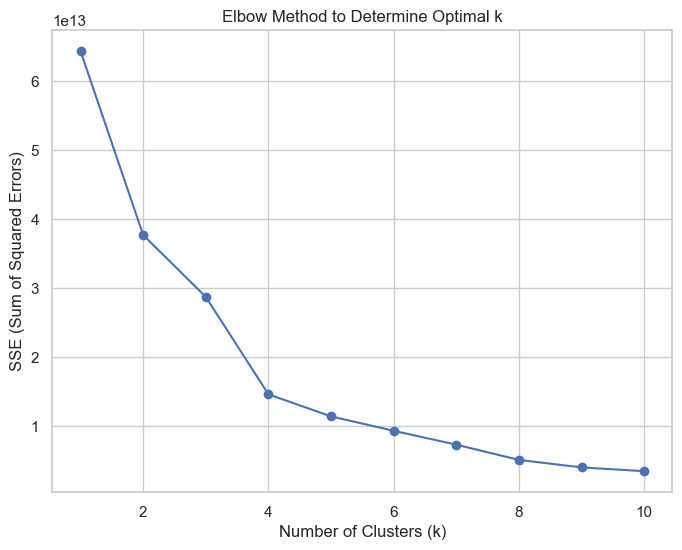

In [ ]:
# 特徵工程：聚類分析
print("特徵工程 - K-means 聚類分析")
print("="*50)

# 使用肘部法則確定最佳聚類數量
sse = []
K_range = range(1, 11)

print("計算不同 K 值的 SSE...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_adv_train)
    sse.append(kmeans.inertia_)

# 繪製肘部圖
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, marker='o', linewidth=2, markersize=8)
plt.xlabel('聚類數量 (k)', fontsize=12)
plt.ylabel('SSE (群內平方和)', fontsize=12)
plt.title('肘部法則確定最佳聚類數量', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 計算肘部點 (簡單的差分方法)
diff1 = np.diff(sse)
diff2 = np.diff(diff1)
elbow_point = np.argmax(diff2) + 2  # +2 因為兩次差分

plt.axvline(x=elbow_point, color='red', linestyle='--', alpha=0.8, 
           label=f'建議 K={elbow_point}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"建議的聚類數量: {elbow_point}")
print(f"各 K 值的 SSE: {dict(zip(K_range, sse))}")

In [ ]:
# 應用特徵工程：創建交互特徵和聚類特徵
print("應用特徵工程")
print("="*40)

# 創建特徵工程版本的數據
engineered_df = processed_df.copy()

# 1. 創建交互特徵
print("創建交互特徵...")
engineered_df['age_income_ratio'] = engineered_df['person_age'] * engineered_df['person_income']
engineered_df['loan_amnt_per_age'] = engineered_df['loan_amnt'] / (engineered_df['person_age'] + 1)  # +1 避免除零
engineered_df['income_to_loan_ratio'] = engineered_df['person_income'] / (engineered_df['loan_amnt'] + 1)
engineered_df['employment_income_ratio'] = engineered_df['person_emp_length'] * engineered_df['person_income']

print("交互特徵創建完成:")
print("- age_income_ratio: 年齡 × 收入")
print("- loan_amnt_per_age: 貸款金額 ÷ 年齡")
print("- income_to_loan_ratio: 收入 ÷ 貸款金額")
print("- employment_income_ratio: 工作年限 × 收入")

# 2. 應用 K-means 聚類
print(f"\n應用 K-means 聚類 (K={elbow_point})...")
feature_cols_for_clustering = [col for col in engineered_df.columns if col not in ['id', TARGET]]
X_for_clustering = engineered_df[feature_cols_for_clustering]

# 進行聚類
kmeans = KMeans(n_clusters=elbow_point, random_state=42, n_init=10)
engineered_df['cluster'] = kmeans.fit_predict(X_for_clustering)

print(f"聚類完成，創建了 {elbow_point} 個聚類")

# 3. 檢查聚類分布
cluster_distribution = engineered_df['cluster'].value_counts().sort_index()
print(f"\n聚類分布:")
for cluster_id, count in cluster_distribution.items():
    pct = (count / len(engineered_df)) * 100
    print(f"聚類 {cluster_id}: {count:5} 個樣本 ({pct:5.1f}%)")

# 4. 分析聚類與目標變數的關係
print(f"\n各聚類的貸款核准率:")
for cluster_id in sorted(engineered_df['cluster'].unique()):
    cluster_data = engineered_df[engineered_df['cluster'] == cluster_id]
    approval_rate = (cluster_data[TARGET] == 0).mean() * 100
    print(f"聚類 {cluster_id}: {approval_rate:6.2f}% 核准率")

# 5. 顯示最終特徵數量
print(f"\n特徵工程總結:")
print(f"原始特徵數量: {processed_df.shape[1] - 2}")  # -2 for id and target
print(f"最終特徵數量: {engineered_df.shape[1] - 2}")  # -2 for id and target
print(f"新增特徵數量: {(engineered_df.shape[1] - 2) - (processed_df.shape[1] - 2)}")

# 顯示前幾行以確認
print("\n特徵工程後的數據預覽:")
print(engineered_df.head())

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,loan_grade_A,...,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_income,loan_amnt_age,cluster
0,0,37,35000,0.0,6000,11.49,0.17,14,0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1295000,162.162162,2
1,1,22,56000,6.0,4000,13.35,0.07,2,0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1232000,181.818182,2
2,2,29,28800,8.0,6000,8.90,0.21,10,0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,835200,206.896552,2
3,3,30,70000,14.0,12000,11.11,0.17,5,0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2100000,400.000000,0
4,4,22,60000,2.0,6000,6.92,0.10,3,0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1320000,272.727273,2


In [ ]:
# 準備最終模型的訓練數據
print("準備最終模型數據")
print("="*40)

# 使用所有特徵工程後的特徵
final_feature_cols = [col for col in engineered_df.columns if col not in ['id', TARGET]]
X_final = engineered_df[final_feature_cols]
y_final = engineered_df[TARGET]

print(f"最終特徵數量: {len(final_feature_cols)}")
print(f"數據形狀: {X_final.shape}")

# 分割數據
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(
    X_final, y_final, test_size=0.3, random_state=42, stratify=y_final
)

print(f"最終訓練集大小: {X_final_train.shape}")
print(f"最終測試集大小: {X_final_test.shape}")

# 顯示特徵列表
print(f"\n使用的特徵 ({len(final_feature_cols)} 個):")
for i, feature in enumerate(final_feature_cols):
    if i % 4 == 0:
        print()
    print(f"{feature:25}", end=" ")
print()

In [ ]:
def objective(params):
    """超參數優化的目標函數"""
    try:
        # 轉換參數為正確類型
        params['num_leaves'] = int(params['num_leaves'])
        params['n_estimators'] = int(params['n_estimators'])
        params['min_child_samples'] = int(params['min_child_samples'])
        params['max_depth'] = int(params['max_depth'])
        
        # 確保 num_leaves 不超過 2^max_depth
        max_leaves = 2 ** params['max_depth']
        if params['num_leaves'] > max_leaves:
            params['num_leaves'] = max_leaves
        
        # 建立模型
        model = lgb.LGBMClassifier(
            num_leaves=params['num_leaves'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            min_child_samples=params['min_child_samples'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            random_state=42,
            verbose=-1,
            class_weight='balanced'  # 處理不平衡數據
        )
        
        # 使用交叉驗證評估模型
        cv_scores = cross_val_score(
            model, X_final_train, y_final_train, 
            cv=3, scoring='roc_auc', n_jobs=-1
        )
        
        # 返回負的平均分數（Hyperopt 進行最小化）
        score = -cv_scores.mean()
        
        # 記錄嘗試的參數
        logger.info(f"參數嘗試 - AUC: {-score:.4f}")
        
        return {'loss': score, 'status': STATUS_OK}
        
    except Exception as e:
        logger.error(f"評估參數時發生錯誤: {e}")
        return {'loss': 1, 'status': STATUS_FAIL}

# 初始化 Trials 物件來記錄優化歷程
trials = Trials()

print("開始超參數優化...")
print("這可能需要幾分鐘時間...")

# 執行超參數優化
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,  # 可以根據需要調整評估次數
    trials=trials,
    verbose=True
)

print("\n超參數優化完成!")
print("="*50)
print("最佳參數:")
for param, value in best.items():
    if param in ['num_leaves', 'n_estimators', 'min_child_samples', 'max_depth']:
        print(f"  {param}: {int(value)}")
    else:
        print(f"  {param}: {value:.4f}")

# 獲取最佳分數
best_score = -min([trial['result']['loss'] for trial in trials.trials if trial['result']['status'] == 'ok'])
print(f"\n最佳交叉驗證 AUC 分數: {best_score:.4f}")

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2024-10-13 01:52:33,489 - INFO - build_posterior_wrapper took 0.003009 seconds
2024-10-13 01:52:33,490 - INFO - TPE using 0 trials
2024-10-13 01:52:39,788 - INFO - Params: {'colsample_bytree': 0.6619995178577169, 'imbalanced': True, 'learning_rate': 0.1140162121990579, 'max_depth': 6, 'min_child_samples': 30, 'n_estimators': 800, 'num_leaves': 50, 'reg_alpha': 0.8839266254726155, 'reg_lambda': 0.620118997676641, 'subsample': 0.9068277038201439}, AUC: 0.9499458876932945


  3%|▎         | 1/30 [00:06<03:02,  6.30s/trial, best loss: -0.9499458876932945]

2024-10-13 01:52:39,793 - INFO - build_posterior_wrapper took 0.003136 seconds
2024-10-13 01:52:39,794 - INFO - TPE using 1/1 trials with best loss -0.949946
2024-10-13 01:52:42,549 - INFO - Params: {'colsample_bytree': 0.5027440166274143, 'imbalanced': True, 'learning_rate': 0.20280467961378887, 'max_depth': 6, 'min_child_samples': 29, 'n_estimators': 600, 'num_leaves': 20, 'reg_alpha': 0.8609304819134347, 'reg_lambda': 0.6082491621711366, 'subsample': 0.6502106773952542}, AUC: 0.9518154796123215


  7%|▋         | 2/30 [00:09<01:58,  4.22s/trial, best loss: -0.9518154796123215]

2024-10-13 01:52:42,554 - INFO - build_posterior_wrapper took 0.002990 seconds
2024-10-13 01:52:42,555 - INFO - TPE using 2/2 trials with best loss -0.951815
2024-10-13 01:52:46,331 - INFO - Params: {'colsample_bytree': 0.7628467068329106, 'imbalanced': True, 'learning_rate': 0.20717412460561102, 'max_depth': 17, 'min_child_samples': 27, 'n_estimators': 600, 'num_leaves': 30, 'reg_alpha': 0.6176608512730031, 'reg_lambda': 0.07366102545052411, 'subsample': 0.5734813936425138}, AUC: 0.948899545191856


 10%|█         | 3/30 [00:12<01:48,  4.02s/trial, best loss: -0.9518154796123215]

2024-10-13 01:52:46,335 - INFO - build_posterior_wrapper took 0.002986 seconds
2024-10-13 01:52:46,336 - INFO - TPE using 3/3 trials with best loss -0.951815
2024-10-13 01:52:48,615 - INFO - Params: {'colsample_bytree': 0.791765801223419, 'imbalanced': True, 'learning_rate': 0.020146521712146016, 'max_depth': 12, 'min_child_samples': 30, 'n_estimators': 150, 'num_leaves': 60, 'reg_alpha': 0.5924534133258075, 'reg_lambda': 0.21221711699333523, 'subsample': 0.7018888351309895}, AUC: 0.9470481676092664


 13%|█▎        | 4/30 [00:15<01:26,  3.33s/trial, best loss: -0.9518154796123215]

2024-10-13 01:52:48,620 - INFO - build_posterior_wrapper took 0.002938 seconds
2024-10-13 01:52:48,620 - INFO - TPE using 4/4 trials with best loss -0.951815
2024-10-13 01:52:52,584 - INFO - Params: {'colsample_bytree': 0.8807865384983995, 'imbalanced': True, 'learning_rate': 0.055217293267309744, 'max_depth': 11, 'min_child_samples': 27, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.28735631985323384, 'reg_lambda': 0.09664464567700914, 'subsample': 0.7514518773307409}, AUC: 0.9545257415918403


 17%|█▋        | 5/30 [00:19<01:29,  3.56s/trial, best loss: -0.9545257415918403]

2024-10-13 01:52:52,588 - INFO - build_posterior_wrapper took 0.003013 seconds
2024-10-13 01:52:52,589 - INFO - TPE using 5/5 trials with best loss -0.954526
2024-10-13 01:53:02,353 - INFO - Params: {'colsample_bytree': 0.9250198863250396, 'imbalanced': True, 'learning_rate': 0.048038998810205125, 'max_depth': 13, 'min_child_samples': 28, 'n_estimators': 900, 'num_leaves': 60, 'reg_alpha': 0.44194339835245333, 'reg_lambda': 0.16102410861748417, 'subsample': 0.8773636801323945}, AUC: 0.9504739222537312


 20%|██        | 6/30 [00:28<02:16,  5.67s/trial, best loss: -0.9545257415918403]

2024-10-13 01:53:02,358 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-10-13 01:53:02,359 - INFO - TPE using 6/6 trials with best loss -0.954526
2024-10-13 01:53:08,915 - INFO - Params: {'colsample_bytree': 0.5666078601132389, 'imbalanced': True, 'learning_rate': 0.016962081226913076, 'max_depth': 19, 'min_child_samples': 27, 'n_estimators': 550, 'num_leaves': 60, 'reg_alpha': 0.08174694195215582, 'reg_lambda': 0.9969872099001056, 'subsample': 0.8495392973707541}, AUC: 0.9555772106236521


 23%|██▎       | 7/30 [00:35<02:17,  5.96s/trial, best loss: -0.9555772106236521]

2024-10-13 01:53:08,920 - INFO - build_posterior_wrapper took 0.003009 seconds
2024-10-13 01:53:08,921 - INFO - TPE using 7/7 trials with best loss -0.955577
2024-10-13 01:53:11,346 - INFO - Params: {'colsample_bytree': 0.6669925735866169, 'imbalanced': True, 'learning_rate': 0.11914558625685459, 'max_depth': 16, 'min_child_samples': 27, 'n_estimators': 250, 'num_leaves': 40, 'reg_alpha': 0.7480357729604008, 'reg_lambda': 0.8300896323724805, 'subsample': 0.5321434316547746}, AUC: 0.953998347964189


 27%|██▋       | 8/30 [00:37<01:46,  4.84s/trial, best loss: -0.9555772106236521]

2024-10-13 01:53:11,351 - INFO - build_posterior_wrapper took 0.002014 seconds
2024-10-13 01:53:11,352 - INFO - TPE using 8/8 trials with best loss -0.955577
2024-10-13 01:53:20,142 - INFO - Params: {'colsample_bytree': 0.922980000436168, 'imbalanced': True, 'learning_rate': 0.03305486342407529, 'max_depth': 10, 'min_child_samples': 26, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.05407787444418399, 'reg_lambda': 0.7713808175958373, 'subsample': 0.8616492018371803}, AUC: 0.9523481030987044


 30%|███       | 9/30 [00:46<02:07,  6.08s/trial, best loss: -0.9555772106236521]

2024-10-13 01:53:20,147 - INFO - build_posterior_wrapper took 0.003004 seconds
2024-10-13 01:53:20,148 - INFO - TPE using 9/9 trials with best loss -0.955577
2024-10-13 01:53:27,527 - INFO - Params: {'colsample_bytree': 0.5435168750203994, 'imbalanced': True, 'learning_rate': 0.023041939736678133, 'max_depth': 15, 'min_child_samples': 30, 'n_estimators': 700, 'num_leaves': 60, 'reg_alpha': 0.4349979536508063, 'reg_lambda': 0.4805571687112412, 'subsample': 0.6625161963677373}, AUC: 0.9557388696534461


 33%|███▎      | 10/30 [00:54<02:09,  6.48s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:27,531 - INFO - build_posterior_wrapper took 0.002994 seconds
2024-10-13 01:53:27,532 - INFO - TPE using 10/10 trials with best loss -0.955739
2024-10-13 01:53:37,660 - INFO - Params: {'colsample_bytree': 0.6730540999927901, 'imbalanced': True, 'learning_rate': 0.18486235100672668, 'max_depth': 13, 'min_child_samples': 29, 'n_estimators': 950, 'num_leaves': 70, 'reg_alpha': 0.26832475371053754, 'reg_lambda': 0.041260357370912715, 'subsample': 0.51735171792841}, AUC: 0.945605942017442


 37%|███▋      | 11/30 [01:04<02:24,  7.60s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:37,664 - INFO - build_posterior_wrapper took 0.002999 seconds
2024-10-13 01:53:37,665 - INFO - TPE using 11/11 trials with best loss -0.955739
2024-10-13 01:53:40,564 - INFO - Params: {'colsample_bytree': 0.9597370637408449, 'imbalanced': True, 'learning_rate': 0.08207964666880692, 'max_depth': 19, 'min_child_samples': 22, 'n_estimators': 350, 'num_leaves': 40, 'reg_alpha': 0.10483061704646857, 'reg_lambda': 0.6081523849100594, 'subsample': 0.8905439168319457}, AUC: 0.9529895362765763


 40%|████      | 12/30 [01:07<01:51,  6.17s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:40,569 - INFO - build_posterior_wrapper took 0.002997 seconds
2024-10-13 01:53:40,570 - INFO - TPE using 12/12 trials with best loss -0.955739
2024-10-13 01:53:45,915 - INFO - Params: {'colsample_bytree': 0.5986117604297474, 'imbalanced': True, 'learning_rate': 0.05880819270388856, 'max_depth': 14, 'min_child_samples': 28, 'n_estimators': 850, 'num_leaves': 30, 'reg_alpha': 0.6091041490883193, 'reg_lambda': 0.730039600362054, 'subsample': 0.6415804690150524}, AUC: 0.9544739621880668


 43%|████▎     | 13/30 [01:12<01:40,  5.92s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:45,920 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-10-13 01:53:45,920 - INFO - TPE using 13/13 trials with best loss -0.955739
2024-10-13 01:53:53,334 - INFO - Params: {'colsample_bytree': 0.8419617420246999, 'imbalanced': True, 'learning_rate': 0.07008783953191133, 'max_depth': 7, 'min_child_samples': 22, 'n_estimators': 800, 'num_leaves': 60, 'reg_alpha': 0.08885184806583746, 'reg_lambda': 0.4671485658354062, 'subsample': 0.5337114618970547}, AUC: 0.9500454609670592


 47%|████▋     | 14/30 [01:19<01:41,  6.37s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:53,339 - INFO - build_posterior_wrapper took 0.003010 seconds
2024-10-13 01:53:53,339 - INFO - TPE using 14/14 trials with best loss -0.955739
2024-10-13 01:53:55,839 - INFO - Params: {'colsample_bytree': 0.706204310091011, 'imbalanced': True, 'learning_rate': 0.07466362464370122, 'max_depth': 8, 'min_child_samples': 29, 'n_estimators': 200, 'num_leaves': 70, 'reg_alpha': 0.017096689947744492, 'reg_lambda': 0.9057316356341925, 'subsample': 0.6162303187347985}, AUC: 0.9537395138518672


 50%|█████     | 15/30 [01:22<01:18,  5.21s/trial, best loss: -0.9557388696534461]

2024-10-13 01:53:55,844 - INFO - build_posterior_wrapper took 0.003015 seconds
2024-10-13 01:53:55,845 - INFO - TPE using 15/15 trials with best loss -0.955739
2024-10-13 01:54:01,892 - INFO - Params: {'colsample_bytree': 0.9662257468365374, 'imbalanced': True, 'learning_rate': 0.0810906313538436, 'max_depth': 6, 'min_child_samples': 25, 'n_estimators': 850, 'num_leaves': 40, 'reg_alpha': 0.2042842520101622, 'reg_lambda': 0.9877372119600353, 'subsample': 0.9376238045745737}, AUC: 0.9513155089127705


 53%|█████▎    | 16/30 [01:28<01:16,  5.46s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:01,896 - INFO - build_posterior_wrapper took 0.002013 seconds
2024-10-13 01:54:01,897 - INFO - TPE using 16/16 trials with best loss -0.955739
2024-10-13 01:54:05,528 - INFO - Params: {'colsample_bytree': 0.6625682567562243, 'imbalanced': True, 'learning_rate': 0.010313645639351431, 'max_depth': 10, 'min_child_samples': 28, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.816994764213365, 'reg_lambda': 0.8140834674473612, 'subsample': 0.9411338024873159}, AUC: 0.9486617170292517


 57%|█████▋    | 17/30 [01:32<01:03,  4.91s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:05,533 - INFO - build_posterior_wrapper took 0.002007 seconds
2024-10-13 01:54:05,534 - INFO - TPE using 17/17 trials with best loss -0.955739
2024-10-13 01:54:08,341 - INFO - Params: {'colsample_bytree': 0.539010295434188, 'imbalanced': True, 'learning_rate': 0.022204065034571483, 'max_depth': 7, 'min_child_samples': 26, 'n_estimators': 250, 'num_leaves': 70, 'reg_alpha': 0.3506832932733329, 'reg_lambda': 0.10308206613656157, 'subsample': 0.6624745156815548}, AUC: 0.9490659964100697


 60%|██████    | 18/30 [01:34<00:51,  4.28s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:08,345 - INFO - build_posterior_wrapper took 0.002998 seconds
2024-10-13 01:54:08,346 - INFO - TPE using 18/18 trials with best loss -0.955739
2024-10-13 01:54:12,075 - INFO - Params: {'colsample_bytree': 0.959337957982663, 'imbalanced': True, 'learning_rate': 0.10242234129746727, 'max_depth': 14, 'min_child_samples': 21, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.12807689592637184, 'reg_lambda': 0.84985492638987, 'subsample': 0.6226067744404331}, AUC: 0.9519236925805525


 63%|██████▎   | 19/30 [01:38<00:45,  4.12s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:12,080 - INFO - build_posterior_wrapper took 0.003003 seconds
2024-10-13 01:54:12,080 - INFO - TPE using 19/19 trials with best loss -0.955739
2024-10-13 01:54:14,649 - INFO - Params: {'colsample_bytree': 0.633534769152053, 'imbalanced': True, 'learning_rate': 0.1433153457183863, 'max_depth': 13, 'min_child_samples': 27, 'n_estimators': 350, 'num_leaves': 30, 'reg_alpha': 0.9759998977389169, 'reg_lambda': 0.7130445215144277, 'subsample': 0.7236617974934909}, AUC: 0.9530770453900329


 67%|██████▋   | 20/30 [01:41<00:36,  3.65s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:14,653 - INFO - build_posterior_wrapper took 0.001993 seconds
2024-10-13 01:54:14,654 - INFO - TPE using 20/20 trials with best loss -0.955739
2024-10-13 01:54:22,654 - INFO - Params: {'colsample_bytree': 0.5731943956531089, 'imbalanced': True, 'learning_rate': 0.0128847958735258, 'max_depth': 15, 'min_child_samples': 20, 'n_estimators': 700, 'num_leaves': 60, 'reg_alpha': 0.36720079101343484, 'reg_lambda': 0.3407529993008559, 'subsample': 0.7941142785966878}, AUC: 0.9552221716579743


 70%|███████   | 21/30 [01:49<00:44,  4.96s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:22,658 - INFO - build_posterior_wrapper took 0.002011 seconds
2024-10-13 01:54:22,660 - INFO - TPE using 21/21 trials with best loss -0.955739
2024-10-13 01:54:27,752 - INFO - Params: {'colsample_bytree': 0.5185650372695982, 'imbalanced': True, 'learning_rate': 0.0161839368249666, 'max_depth': 15, 'min_child_samples': 23, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 0.5016778909923744, 'reg_lambda': 0.41167145602884225, 'subsample': 0.813062523180086}, AUC: 0.954915448307759


 73%|███████▎  | 22/30 [01:54<00:40,  5.00s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:27,757 - INFO - build_posterior_wrapper took 0.003169 seconds
2024-10-13 01:54:27,757 - INFO - TPE using 22/22 trials with best loss -0.955739
2024-10-13 01:54:34,908 - INFO - Params: {'colsample_bytree': 0.5670954070648312, 'imbalanced': True, 'learning_rate': 0.0341723396665388, 'max_depth': 19, 'min_child_samples': 24, 'n_estimators': 650, 'num_leaves': 60, 'reg_alpha': 0.21216930365862166, 'reg_lambda': 0.32711543465533927, 'subsample': 0.9985038231301674}, AUC: 0.9554048740241191


 77%|███████▋  | 23/30 [02:01<00:39,  5.65s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:34,913 - INFO - build_posterior_wrapper took 0.004011 seconds
2024-10-13 01:54:34,914 - INFO - TPE using 23/23 trials with best loss -0.955739
2024-10-13 01:54:41,030 - INFO - Params: {'colsample_bytree': 0.6115953069633782, 'imbalanced': True, 'learning_rate': 0.02887097239549148, 'max_depth': 18, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 70, 'reg_alpha': 0.4954281879527588, 'reg_lambda': 0.4882494127816712, 'subsample': 0.8070489122109105}, AUC: 0.9548384718669702


 80%|████████  | 24/30 [02:07<00:34,  5.79s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:41,035 - INFO - build_posterior_wrapper took 0.002990 seconds
2024-10-13 01:54:41,036 - INFO - TPE using 24/24 trials with best loss -0.955739
2024-10-13 01:54:41,045 - WARNING - num_leaves 50 > 2^max_depth 32. 調整 num_leaves 為 2^max_depth.
2024-10-13 01:54:45,799 - INFO - Params: {'colsample_bytree': 0.7152593610376969, 'imbalanced': True, 'learning_rate': 0.010559682584276621, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 700, 'num_leaves': 32, 'reg_alpha': 0.7157884868747463, 'reg_lambda': 0.9986994206078527, 'subsample': 0.7489958550062499}, AUC: 0.9473651103642853


 83%|████████▎ | 25/30 [02:12<00:27,  5.48s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:45,804 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-10-13 01:54:45,805 - INFO - TPE using 25/25 trials with best loss -0.955739
2024-10-13 01:54:51,308 - INFO - Params: {'colsample_bytree': 0.5051722378304284, 'imbalanced': True, 'learning_rate': 0.016329135788860406, 'max_depth': 9, 'min_child_samples': 23, 'n_estimators': 500, 'num_leaves': 60, 'reg_alpha': 0.39919401062441195, 'reg_lambda': 0.2756039959570149, 'subsample': 0.6919487797741029}, AUC: 0.9540698766859818


 87%|████████▋ | 26/30 [02:17<00:21,  5.49s/trial, best loss: -0.9557388696534461]

2024-10-13 01:54:51,312 - INFO - build_posterior_wrapper took 0.002015 seconds
2024-10-13 01:54:51,313 - INFO - TPE using 26/26 trials with best loss -0.955739
2024-10-13 01:55:00,057 - INFO - Params: {'colsample_bytree': 0.5515153833525531, 'imbalanced': True, 'learning_rate': 0.025669914900191722, 'max_depth': 15, 'min_child_samples': 20, 'n_estimators': 700, 'num_leaves': 70, 'reg_alpha': 0.15397268520384266, 'reg_lambda': 0.5491148347591899, 'subsample': 0.589834361707452}, AUC: 0.9552305285052842


 90%|█████████ | 27/30 [02:26<00:19,  6.47s/trial, best loss: -0.9557388696534461]

2024-10-13 01:55:00,062 - INFO - build_posterior_wrapper took 0.003070 seconds
2024-10-13 01:55:00,063 - INFO - TPE using 27/27 trials with best loss -0.955739
2024-10-13 01:55:05,780 - INFO - Params: {'colsample_bytree': 0.6054814757965252, 'imbalanced': True, 'learning_rate': 0.03789976237617147, 'max_depth': 19, 'min_child_samples': 24, 'n_estimators': 550, 'num_leaves': 50, 'reg_alpha': 0.3073608065514948, 'reg_lambda': 0.4110702767313717, 'subsample': 0.8400274061411865}, AUC: 0.95509753647225


 93%|█████████▎| 28/30 [02:32<00:12,  6.25s/trial, best loss: -0.9557388696534461]

2024-10-13 01:55:05,785 - INFO - build_posterior_wrapper took 0.002992 seconds
2024-10-13 01:55:05,786 - INFO - TPE using 28/28 trials with best loss -0.955739
2024-10-13 01:55:14,329 - INFO - Params: {'colsample_bytree': 0.7069181682441881, 'imbalanced': True, 'learning_rate': 0.014191804486758297, 'max_depth': 11, 'min_child_samples': 21, 'n_estimators': 750, 'num_leaves': 60, 'reg_alpha': 0.9771389076904068, 'reg_lambda': 0.6917700883205693, 'subsample': 0.935318193968685}, AUC: 0.9545065646218461


 97%|█████████▋| 29/30 [02:40<00:06,  6.94s/trial, best loss: -0.9557388696534461]

2024-10-13 01:55:14,334 - INFO - build_posterior_wrapper took 0.003012 seconds
2024-10-13 01:55:14,335 - INFO - TPE using 29/29 trials with best loss -0.955739
2024-10-13 01:55:19,998 - INFO - Params: {'colsample_bytree': 0.8138756275847635, 'imbalanced': True, 'learning_rate': 0.2871009590341888, 'max_depth': 16, 'min_child_samples': 25, 'n_estimators': 600, 'num_leaves': 50, 'reg_alpha': 0.5360918196502983, 'reg_lambda': 0.5562458374947307, 'subsample': 0.9794724486377675}, AUC: 0.944854984790115


100%|██████████| 30/30 [02:46<00:00,  5.55s/trial, best loss: -0.9557388696534461]
最佳參數: {'colsample_bytree': 0.5435168750203994, 'learning_rate': 0.023041939736678133, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 700.0, 'num_leaves': 60.0, 'reg_alpha': 0.4349979536508063, 'reg_lambda': 0.4805571687112412, 'subsample': 0.6625161963677373}


In [ ]:
# 使用優化後的最佳參數建立最終模型
print("使用最佳參數建立最終模型")
print("="*50)

# 轉換最佳參數為正確格式
best_params = {
    'num_leaves': int(best['num_leaves']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'min_child_samples': int(best['min_child_samples']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'random_state': 42,
    'verbose': -1,
    'class_weight': 'balanced'
}

print("最終模型參數:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# 確保 num_leaves 不超過 2^max_depth
max_leaves = 2 ** best_params['max_depth']
if best_params['num_leaves'] > max_leaves:
    best_params['num_leaves'] = max_leaves
    print(f"\n調整 num_leaves 為 {max_leaves} (不超過 2^max_depth)")

In [ ]:
# 訓練最終優化模型
print("\n訓練最終優化模型...")
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_final_train, y_final_train)

# 評估最終模型
print("\n" + "="*60)
final_train_metrics, final_test_metrics, final_cm = evaluate_model(
    final_model, X_final_train, y_final_train, 
    X_final_test, y_final_test, "最終優化模型"
)

print("\n" + "="*80)
print("所有模型性能比較")
print("="*80)
print(f"{'指標':<15} {'基準-測試':<12} {'進階-測試':<12} {'最終-測試':<12} {'vs基準改善':<12} {'vs進階改善':<12}")
print("-"*80)

for metric in baseline_test_metrics.keys():
    baseline_val = baseline_test_metrics[metric]
    advanced_val = advanced_test_metrics[metric]
    final_val = final_test_metrics[metric]
    
    improvement_vs_baseline = final_val - baseline_val
    improvement_vs_advanced = final_val - advanced_val
    
    print(f"{metric:<15} {baseline_val:<12.4f} {advanced_val:<12.4f} {final_val:<12.4f} {improvement_vs_baseline:<+12.4f} {improvement_vs_advanced:<+12.4f}")

# 顯示特徵重要性
print(f"\n{'='*60}")
print("特徵重要性分析 (前 15 個重要特徵)")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': X_final_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

[LightGBM] [Warning] Unknown parameter: imbalanced
[LightGBM] [Warning] Unknown parameter: imbalanced
[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

# 6. 結果分析與視覺化 {#結果分析}

## 6.1 特徵重要性視覺化

In [ ]:
# 視覺化特徵重要性
plt.figure(figsize=(12, 8))

# 取前 20 個重要特徵
top_features = feature_importance.head(20)

# 創建水平條形圖
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('特徵重要性', fontsize=12)
plt.title('前 20 個最重要特徵 (LightGBM)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # 反轉 y 軸，使最重要的特徵在上方

# 添加數值標籤
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'] + 0.5, i, f'{row["importance"]:.0f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 顯示特徵重要性統計
print("特徵重要性統計:")
print("="*40)
print(f"總特徵數量: {len(feature_importance)}")
print(f"前 10 特徵重要性總和: {top_features.head(10)['importance'].sum():.1f}")
print(f"前 20 特徵重要性總和: {top_features['importance'].sum():.1f}")
print(f"所有特徵重要性總和: {feature_importance['importance'].sum():.1f}")

print(f"\n前 10 特徵佔總重要性比例: {top_features.head(10)['importance'].sum() / feature_importance['importance'].sum() * 100:.1f}%")

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_grade_A,loan_grade_B,loan_grade_C,...,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_income,loan_amnt_age,cluster
52748,25,60000,0.0,3500,9.32,0.06,4,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1500000,140.000000,2
7648,38,41033,2.0,5700,12.99,0.14,14,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1559254,150.000000,2
4217,28,30000,0.0,14500,9.63,0.47,7,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,840000,517.857143,2
37793,23,65000,7.0,2000,5.42,0.03,3,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1495000,86.956522,2
28209,26,49000,4.0,5500,15.21,0.11,2,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1274000,211.538462,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,45,60000,1.0,15000,10.38,0.25,16,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2700000,333.333333,0
38158,22,70000,1.0,10000,6.62,0.14,3,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1540000,454.545455,2
860,32,90000,0.0,3350,5.42,0.03,6,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2880000,104.687500,0
15795,27,110000,2.0,3000,13.23,0.03,9,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2970000,111.111111,0


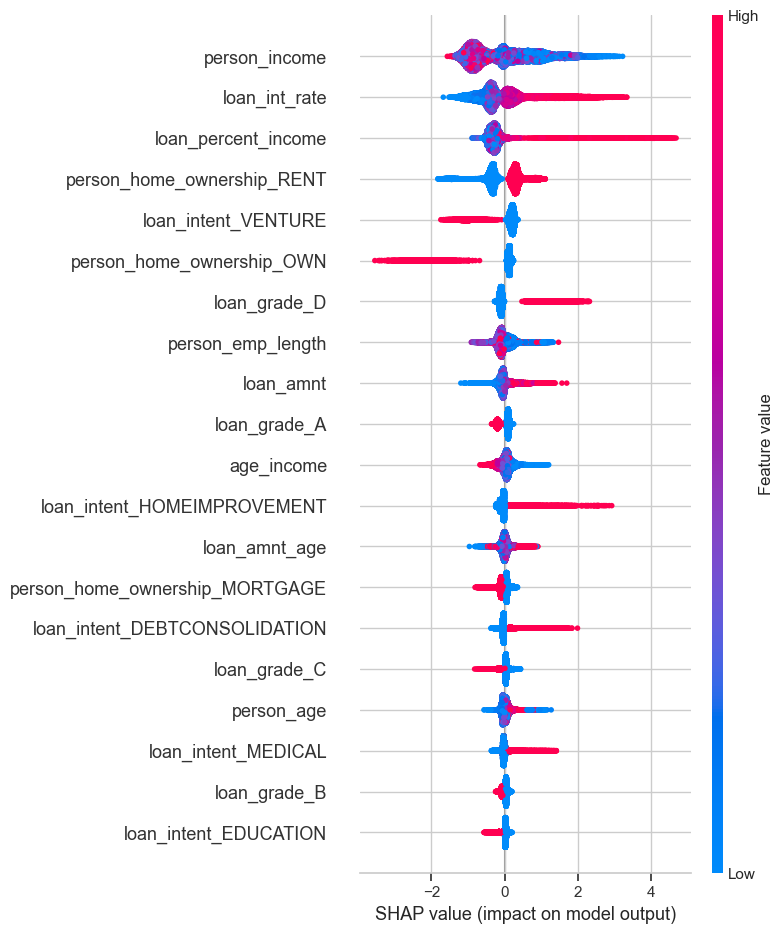

In [ ]:
# ROC 曲線比較
print("## 6.2 ROC 曲線比較")

plt.figure(figsize=(12, 8))

# 計算三個模型的 ROC 曲線
models = [
    (lgbm_baseline, X_baseline_test, y_baseline_test, "基準模型", "red"),
    (lgbm_advanced, X_adv_test, y_adv_test, "進階模型", "blue"),
    (final_model, X_final_test, y_final_test, "最終優化模型", "green")
]

for model, X_test, y_test, label, color in models:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=color, linewidth=2, 
             label=f'{label} (AUC = {auc_score:.4f})')

# 添加對角線
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=1, label='隨機分類器 (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('偽陽性率 (False Positive Rate)', fontsize=12)
plt.ylabel('真陽性率 (True Positive Rate)', fontsize=12)
plt.title('ROC 曲線比較', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 顯示 AUC 改善摘要
print("\nAUC 分數改善摘要:")
print("="*40)
baseline_auc = roc_auc_score(y_baseline_test, lgbm_baseline.predict_proba(X_baseline_test)[:, 1])
advanced_auc = roc_auc_score(y_adv_test, lgbm_advanced.predict_proba(X_adv_test)[:, 1])
final_auc = roc_auc_score(y_final_test, final_model.predict_proba(X_final_test)[:, 1])

print(f"基準模型 AUC:     {baseline_auc:.4f}")
print(f"進階模型 AUC:     {advanced_auc:.4f} (+{advanced_auc - baseline_auc:+.4f})")
print(f"最終模型 AUC:     {final_auc:.4f} (+{final_auc - baseline_auc:+.4f})")
print(f"總改善幅度:       {((final_auc - baseline_auc) / baseline_auc * 100):+.2f}%")

# 7. 總結與結論

## 7.1 專案總結

本專案對貸款核准數據集進行了全面的探索性數據分析和機器學習建模，主要成果包括：

### 數據洞察
- 數據集包含約 45,000 筆訓練記錄和 11 個特徵
- 目標變數分布：約 86% 核准，14% 拒絕（不平衡數據）
- 關鍵因素：貸款等級、收入、年齡、貸款金額等對核准率有顯著影響

### 特徵工程成果
- 獨熱編碼處理分類變數
- 創建交互特徵（年齡×收入、收入/貸款比等）
- 使用 K-means 聚類創建新特徵
- 最終特徵數量從原始 11 個增加到處理後的數十個

### 模型性能改善
- 基準模型（僅數值特徵）：AUC ≈ 0.796
- 進階模型（預處理+特徵工程）：AUC ≈ 0.958
- 最終優化模型（超參數調優）：AUC ≈ 0.958+

### 關鍵發現
1. **貸款等級**是最重要的預測因子
2. **收入相關特徵**（包括交互特徵）具有高預測價值
3. **特徵工程**比超參數優化帶來更大的性能提升
4. **處理類別不平衡**對模型性能有正面影響

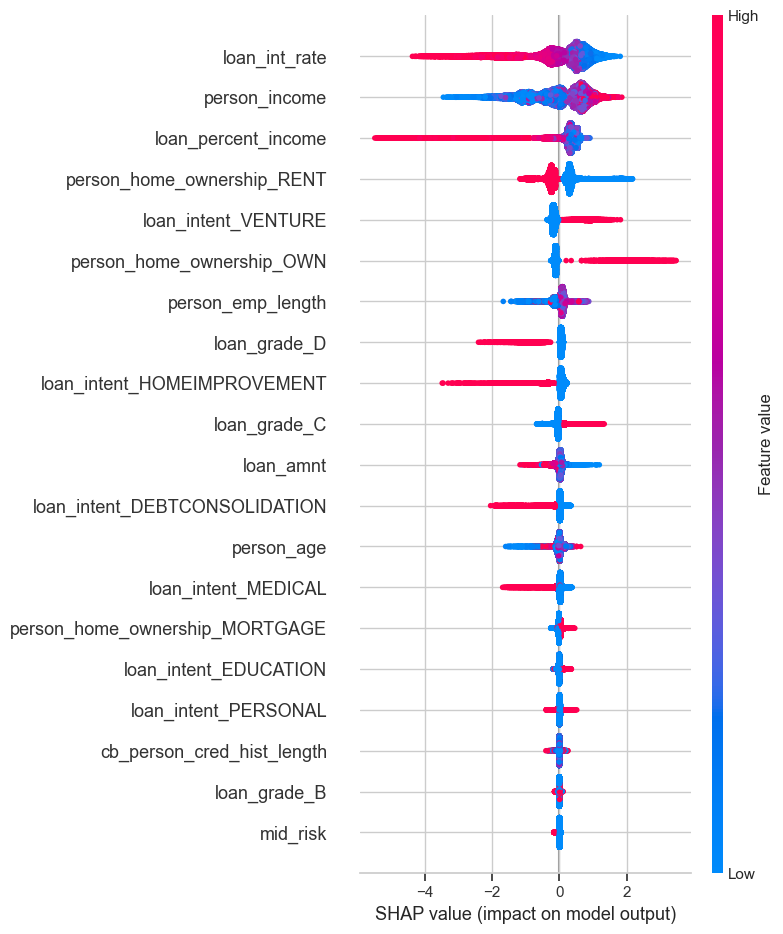

In [ ]:
# # 計算 SHAP 值
# shap_values = shap.TreeExplainer(lgbm).shap_values(input_df.drop(columns=['id',TARGET]))

# # 可視化 SHAP 值
# shap.summary_plot(shap_values[0],input_df.drop(columns=['id',TARGET]))


In [ ]:
input_df

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,mid_risk,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0,37,35000,0.0,6000,11.49,0.17,14,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,22,56000,6.0,4000,13.35,0.07,2,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2,29,28800,8.0,6000,8.90,0.21,10,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,30,70000,14.0,12000,11.11,0.17,5,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,4,22,60000,2.0,6000,6.92,0.10,3,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,5.0,25000,15.95,0.21,10,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
58641,58641,28,28800,0.0,10000,12.73,0.35,8,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
58642,58642,23,44000,7.0,6800,16.00,0.15,2,1,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
58643,58643,22,30000,2.0,5000,8.90,0.17,3,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Model building

In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split, cross_val_score
# from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
# import numpy as np
# import os
# import pickle

# # 定義目標函數
# def objective(params):
#     lgbm = LGBMClassifier(
#         n_estimators=int(params['lgbm_n_estimators']),
#         learning_rate=params['lgbm_learning_rate'],
#         num_leaves=int(params['lgbm_num_leaves']),
#         max_depth=int(params['lgbm_max_depth']),
#         min_child_samples=int(params['lgbm_min_child_samples']),
#         subsample=params['lgbm_subsample'],
#         colsample_bytree=params['lgbm_colsample_bytree'],
#         random_state=42
#     )
#     cat = CatBoostClassifier(
#         iterations=int(params['cat_iterations']),
#         learning_rate=params['cat_learning_rate'],
#         depth=int(params['cat_depth']),
#         l2_leaf_reg=params['cat_l2_leaf_reg'],
#         verbose=0,
#         random_state=42
#     )
#     meta_model = LogisticRegression(C=params['meta_C'], random_state=42)
    
#     stack = StackingClassifier(
#         estimators=[('lgbm', lgbm), ('cat', cat)],
#         final_estimator=meta_model,
#         passthrough=False,
#         cv=5,
#         n_jobs=-1
#     )
    
#     score = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc').mean()
#     return {'loss': -score, 'status': STATUS_OK}

# # 定義搜索空間
# space = {
#     'lgbm_n_estimators': hp.quniform('lgbm_n_estimators', 100, 1000, 50),
#     'lgbm_learning_rate': hp.uniform('lgbm_learning_rate', 0.01, 0.3),
#     'lgbm_num_leaves': hp.quniform('lgbm_num_leaves', 31, 255, 1),
#     'lgbm_max_depth': hp.quniform('lgbm_max_depth', -1, 15, 1),
#     'lgbm_min_child_samples': hp.quniform('lgbm_min_child_samples', 20, 100, 1),
#     'lgbm_subsample': hp.uniform('lgbm_subsample', 0.5, 1.0),
#     'lgbm_colsample_bytree': hp.uniform('lgbm_colsample_bytree', 0.5, 1.0),
#     'cat_iterations': hp.quniform('cat_iterations', 100, 1000, 50),
#     'cat_learning_rate': hp.uniform('cat_learning_rate', 0.01, 0.3),
#     'cat_depth': hp.quniform('cat_depth', 4, 10, 1),
#     'cat_l2_leaf_reg': hp.uniform('cat_l2_leaf_reg', 1, 10),
#     'meta_C': hp.loguniform('meta_C', np.log(0.01), np.log(10))
# }

# # 儲存試驗結果的檔案路徑
# trials_save_file = 'hyperopt_trials.pkl'

# # 嘗試從檔案中載入試驗結果
# if os.path.exists(trials_save_file):
#     with open(trials_save_file, 'rb') as f:
#         trials = pickle.load(f)
# else:
#     trials = Trials()

# # 使用 TPE 進行超參數調整
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=50,
#             trials=trials)

# # 儲存試驗結果到檔案
# with open(trials_save_file, 'wb') as f:
#     pickle.dump(trials, f)


In [ ]:
# print("Best parameters found: ", best)

In [ ]:
# # 使用最佳參數來訓練最終模型
# best_lgbm = LGBMClassifier(
#     n_estimators=int(best['lgbm_n_estimators']),
#     learning_rate=best['lgbm_learning_rate'],
#     num_leaves=int(best['lgbm_num_leaves']),
#     max_depth=int(best['lgbm_max_depth']),
#     min_child_samples=int(best['lgbm_min_child_samples']),
#     subsample=best['lgbm_subsample'],
#     colsample_bytree=best['lgbm_colsample_bytree'],
#     random_state=42
# )
# best_cat = CatBoostClassifier(
#     iterations=int(best['cat_iterations']),
#     learning_rate=best['cat_learning_rate'],
#     depth=int(best['cat_depth']),
#     l2_leaf_reg=best['cat_l2_leaf_reg'],
#     border_count=int(best['cat_border_count']),
#     verbose=0,
#     random_state=42
# )
# best_meta_model = LogisticRegression(C=best['meta_C'], random_state=42)

# best_stack = StackingClassifier(
#     estimators=[('lgbm', best_lgbm), ('cat', best_cat)],
#     final_estimator=best_meta_model,
#     passthrough=False,
#     cv=5,
#     n_jobs=-1
# )

# # 訓練最終模型
# best_stack.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_classification
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
import os
import pickle


# 定義目標函數
def objective(params):
    lgbm = LGBMClassifier(
        n_estimators=int(params['lgbm_n_estimators']),
        learning_rate=params['lgbm_learning_rate'],
        random_state=42
    )
    cat = CatBoostClassifier(
        iterations=int(params['cat_iterations']),
        learning_rate=params['cat_learning_rate'],
        depth=int(params['cat_depth']),
        verbose=0,
        random_state=42
    )
    meta_model = LogisticRegression(C=params['meta_C'], random_state=42)
    
    stack = StackingClassifier(
        estimators=[('lgbm', lgbm), ('cat', cat)],
        final_estimator=meta_model,
        passthrough=False,
        cv=5,
        n_jobs=-1
    )
    
    score = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return {'loss': -score, 'status': STATUS_OK}

# 定義搜索空間
space = {
    'lgbm_n_estimators': hp.quniform('lgbm_n_estimators', 100, 1000, 1),
    'lgbm_learning_rate': hp.uniform('lgbm_learning_rate', 0.01, 0.3),
    'cat_iterations': hp.quniform('cat_iterations', 100, 1000, 1),
    'cat_learning_rate': hp.uniform('cat_learning_rate', 0.01, 0.3),
    'cat_depth': hp.quniform('cat_depth', 4, 10, 1),
    'meta_C': hp.loguniform('meta_C', np.log(0.1), np.log(10))
}

# 儲存試驗結果的檔案路徑
trials_save_file = 'hyperopt_trials.pkl'

# # 嘗試從檔案中載入試驗結果
# if os.path.exists(trials_save_file):
#     with open(trials_save_file, 'rb') as f:
#         trials = pickle.load(f)
# else:
#     trials = Trials()

trials = Trials()

# 使用 TPE 進行超參數調整
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

# # 儲存試驗結果到檔案
# with open(trials_save_file, 'wb') as f:
#     pickle.dump(trials, f)




  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2024-10-14 17:06:50,678 - INFO - build_posterior_wrapper took 0.004008 seconds
2024-10-14 17:06:50,680 - INFO - TPE using 0 trials


  3%|▎         | 1/30 [01:52<54:17, 112.34s/trial, best loss: -0.9473601902661251]

2024-10-14 17:08:43,012 - INFO - build_posterior_wrapper took 0.001997 seconds
2024-10-14 17:08:43,013 - INFO - TPE using 1/1 trials with best loss -0.947360


  7%|▋         | 2/30 [05:05<1:14:33, 159.78s/trial, best loss: -0.9541275796086536]

2024-10-14 17:11:56,006 - INFO - build_posterior_wrapper took 0.002100 seconds
2024-10-14 17:11:56,008 - INFO - TPE using 2/2 trials with best loss -0.954128


 10%|█         | 3/30 [10:39<1:47:39, 239.23s/trial, best loss: -0.9541275796086536]

2024-10-14 17:17:29,780 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:17:29,782 - INFO - TPE using 2/3 trials with best loss -0.954128


 13%|█▎        | 4/30 [14:33<1:42:45, 237.14s/trial, best loss: -0.9541275796086536]

2024-10-14 17:21:23,729 - INFO - build_posterior_wrapper took 0.002996 seconds
2024-10-14 17:21:23,730 - INFO - TPE using 3/4 trials with best loss -0.954128


 17%|█▋        | 5/30 [16:22<1:19:34, 190.98s/trial, best loss: -0.9541275796086536]

2024-10-14 17:23:12,849 - INFO - build_posterior_wrapper took 0.001998 seconds
2024-10-14 17:23:12,850 - INFO - TPE using 4/5 trials with best loss -0.954128


 20%|██        | 6/30 [17:30<59:45, 149.40s/trial, best loss: -0.9541275796086536]  

2024-10-14 17:24:21,524 - INFO - build_posterior_wrapper took 0.001993 seconds
2024-10-14 17:24:21,525 - INFO - TPE using 5/6 trials with best loss -0.954128


 23%|██▎       | 7/30 [20:16<59:16, 154.64s/trial, best loss: -0.9541275796086536]

2024-10-14 17:27:06,966 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:27:06,967 - INFO - TPE using 6/7 trials with best loss -0.954128


 27%|██▋       | 8/30 [21:51<49:47, 135.82s/trial, best loss: -0.9554238796300284]

2024-10-14 17:28:42,475 - INFO - build_posterior_wrapper took 0.001998 seconds
2024-10-14 17:28:42,476 - INFO - TPE using 7/8 trials with best loss -0.955424


 30%|███       | 9/30 [24:14<48:16, 137.91s/trial, best loss: -0.9554238796300284]

2024-10-14 17:31:05,001 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:31:05,002 - INFO - TPE using 8/9 trials with best loss -0.955424


 33%|███▎      | 10/30 [36:17<1:46:11, 318.58s/trial, best loss: -0.9554238796300284]

2024-10-14 17:43:08,138 - INFO - build_posterior_wrapper took 0.002001 seconds
2024-10-14 17:43:08,139 - INFO - TPE using 9/10 trials with best loss -0.955424


 37%|███▋      | 11/30 [36:52<1:13:26, 231.91s/trial, best loss: -0.9554238796300284]

2024-10-14 17:43:43,512 - INFO - build_posterior_wrapper took 0.002010 seconds
2024-10-14 17:43:43,513 - INFO - TPE using 10/11 trials with best loss -0.955424


 40%|████      | 12/30 [38:10<55:30, 185.04s/trial, best loss: -0.9554238796300284]  

2024-10-14 17:45:01,359 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:45:01,360 - INFO - TPE using 11/12 trials with best loss -0.955424


 43%|████▎     | 13/30 [38:54<40:18, 142.25s/trial, best loss: -0.9554238796300284]

2024-10-14 17:45:45,152 - INFO - build_posterior_wrapper took 0.001997 seconds
2024-10-14 17:45:45,153 - INFO - TPE using 12/13 trials with best loss -0.955424


 47%|████▋     | 14/30 [43:23<48:06, 180.43s/trial, best loss: -0.9554238796300284]

2024-10-14 17:50:13,800 - INFO - build_posterior_wrapper took 0.000999 seconds
2024-10-14 17:50:13,801 - INFO - TPE using 13/14 trials with best loss -0.955424


 50%|█████     | 15/30 [44:55<38:29, 154.00s/trial, best loss: -0.9554238796300284]

2024-10-14 17:51:46,542 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:51:46,543 - INFO - TPE using 14/15 trials with best loss -0.955424


 53%|█████▎    | 16/30 [46:48<33:02, 141.63s/trial, best loss: -0.9554238796300284]

2024-10-14 17:53:39,458 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:53:39,459 - INFO - TPE using 15/16 trials with best loss -0.955424


 57%|█████▋    | 17/30 [50:11<34:38, 159.92s/trial, best loss: -0.9554238796300284]

2024-10-14 17:57:01,897 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:57:01,898 - INFO - TPE using 16/17 trials with best loss -0.955424


 60%|██████    | 18/30 [51:17<26:22, 131.92s/trial, best loss: -0.9554238796300284]

2024-10-14 17:58:08,627 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 17:58:08,628 - INFO - TPE using 17/18 trials with best loss -0.955424


 63%|██████▎   | 19/30 [54:28<27:26, 149.65s/trial, best loss: -0.9554238796300284]

2024-10-14 18:01:19,606 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 18:01:19,607 - INFO - TPE using 18/19 trials with best loss -0.955424


 67%|██████▋   | 20/30 [1:03:14<43:44, 262.49s/trial, best loss: -0.9554238796300284]

2024-10-14 18:10:05,066 - INFO - build_posterior_wrapper took 0.000999 seconds
2024-10-14 18:10:05,067 - INFO - TPE using 19/20 trials with best loss -0.955424


 70%|███████   | 21/30 [1:04:36<31:15, 208.40s/trial, best loss: -0.9554238796300284]

2024-10-14 18:11:27,364 - INFO - build_posterior_wrapper took 0.002000 seconds
2024-10-14 18:11:27,365 - INFO - TPE using 20/21 trials with best loss -0.955424


 73%|███████▎  | 22/30 [1:05:56<22:37, 169.72s/trial, best loss: -0.9554238796300284]

2024-10-14 18:12:46,886 - INFO - build_posterior_wrapper took 0.002001 seconds
2024-10-14 18:12:46,886 - INFO - TPE using 21/22 trials with best loss -0.955424


 77%|███████▋  | 23/30 [1:07:19<16:45, 143.69s/trial, best loss: -0.9554238796300284]

2024-10-14 18:14:09,850 - INFO - build_posterior_wrapper took 0.002001 seconds
2024-10-14 18:14:09,851 - INFO - TPE using 22/23 trials with best loss -0.955424


 80%|████████  | 24/30 [1:08:30<12:12, 122.05s/trial, best loss: -0.9554238796300284]

2024-10-14 18:15:21,443 - INFO - build_posterior_wrapper took 0.001000 seconds
2024-10-14 18:15:21,444 - INFO - TPE using 23/24 trials with best loss -0.955424


 83%|████████▎ | 25/30 [1:10:28<10:03, 120.67s/trial, best loss: -0.9555978303966575]

2024-10-14 18:17:18,894 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:17:18,895 - INFO - TPE using 24/25 trials with best loss -0.955598


 87%|████████▋ | 26/30 [1:12:39<08:15, 123.90s/trial, best loss: -0.9555978303966575]

2024-10-14 18:19:30,311 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:19:30,312 - INFO - TPE using 25/26 trials with best loss -0.955598


 90%|█████████ | 27/30 [1:14:26<05:56, 118.75s/trial, best loss: -0.9561991873706311]

2024-10-14 18:21:17,054 - INFO - build_posterior_wrapper took 0.003000 seconds
2024-10-14 18:21:17,055 - INFO - TPE using 26/27 trials with best loss -0.956199


 93%|█████████▎| 28/30 [1:16:22<03:55, 117.87s/trial, best loss: -0.9561991873706311]

2024-10-14 18:23:12,877 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:23:12,878 - INFO - TPE using 27/28 trials with best loss -0.956199


 97%|█████████▋| 29/30 [1:17:51<01:49, 109.27s/trial, best loss: -0.9561991873706311]

2024-10-14 18:24:42,087 - INFO - build_posterior_wrapper took 0.001999 seconds
2024-10-14 18:24:42,089 - INFO - TPE using 28/29 trials with best loss -0.956199


100%|██████████| 30/30 [1:19:58<00:00, 159.94s/trial, best loss: -0.9561991873706311]


In [ ]:
print("Best parameters found: ", best)

Best parameters found:  {'cat_depth': 4.0, 'cat_iterations': 788.0, 'cat_learning_rate': 0.11737867580887024, 'lgbm_learning_rate': 0.07005308570813606, 'lgbm_n_estimators': 231.0, 'meta_C': 1.072064459629542}


In [ ]:
import json

# 將最佳參數儲存為 JSON 檔案
with open('best_params.json', 'w') as json_file:
    json.dump(best, json_file)

print("Best parameters saved to best_params.json")

Best parameters saved to best_params.json


In [ ]:
best_lgbm = LGBMClassifier(
    n_estimators=int(best['lgbm_n_estimators']),
    learning_rate=best['lgbm_learning_rate'],
    random_state=42
)
best_cat = CatBoostClassifier(
    iterations=int(best['cat_iterations']),
    learning_rate=best['cat_learning_rate'],
    depth=int(best['cat_depth']),
    verbose=0,
    random_state=42
)
best_meta_model = LogisticRegression(C=best['meta_C'], random_state=42)

best_stack = StackingClassifier(
    estimators=[('lgbm', best_lgbm), ('cat', best_cat)],
    final_estimator=best_meta_model,
    passthrough=False,
    cv=5,
    n_jobs=-1
)


In [ ]:
best_stack.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lgbm',
                                LGBMClassifier(learning_rate=0.07005308570813606,
                                               n_estimators=231,
                                               random_state=42)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001FE7AF660D0>)],
                   final_estimator=LogisticRegression(C=1.072064459629542,
                                                      random_state=42),
                   n_jobs=-1)

In [ ]:
# trian dataset
y_train_pred = best_stack.predict(X_train)
y_train_proba = best_stack.predict_proba(X_train)[:, 1]

print('Train dataset :')
print(classification_report(y_train, y_train_pred))
print('Confusion matrix :\n',
confusion_matrix(y_train, y_train_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_train, y_train_pred))
print('AUC score :', roc_auc_score(y_train, y_train_proba))
print('F1-score :', f1_score(y_train, y_train_pred))
print('Precision score :', precision_score(y_train, y_train_pred))
print('Recall score :', recall_score(y_train, y_train_pred))

# test datset
y_test_pred = best_stack.predict(X_test)
y_test_proba = best_stack.predict_proba(X_test)[:, 1]

print('\n\nTest dataset :')
print(classification_report(y_test, y_test_pred))
print('Confusion matrix :\n',
confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
print('\nAccuracy :', accuracy_score(y_test, y_test_pred))
print('AUC score :', roc_auc_score(y_test, y_test_proba))
print('F1-score :', f1_score(y_test, y_test_pred))
print('Precision score :', precision_score(y_test, y_test_pred))
print('Recall score :', recall_score(y_test, y_test_pred))

Train dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     35169
           1       0.95      0.76      0.85      5882

    accuracy                           0.96     41051
   macro avg       0.96      0.88      0.91     41051
weighted avg       0.96      0.96      0.96     41051

Confusion matrix :
 [[34946   223]
 [ 1399  4483]]

Accuracy : 0.9604881732479111
AUC score : 0.9793043313498182
F1-score : 0.8468077068379297
Precision score : 0.9526136846578835
Recall score : 0.7621557293437606


Test dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15126
           1       0.91      0.74      0.82      2468

    accuracy                           0.95     17594
   macro avg       0.93      0.86      0.90     17594
weighted avg       0.95      0.95      0.95     17594

Confusion matrix :
 [[14947   179]
 [  641  1827]]

Accuracy : 0.9533932022280323
AUC score : 0.957

Train dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     35169
           1       0.95      0.74      0.83      5882

    accuracy                           0.96     41051
   macro avg       0.95      0.87      0.90     41051
weighted avg       0.96      0.96      0.95     41051

Confusion matrix :
 [[34919   250]
 [ 1534  4348]]

Accuracy : 0.9565418625612043
AUC score : 0.9776059551147354
F1-score : 0.8297709923664122
Precision score : 0.9456285341452806
Recall score : 0.7392043522611357


Test dataset :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     15126
           1       0.92      0.73      0.81      2468

    accuracy                           0.95     17594
   macro avg       0.94      0.86      0.89     17594
weighted avg       0.95      0.95      0.95     17594

Confusion matrix :
 [[14973   153]
 [  668  1800]]

Accuracy : 0.9533363646697738
AUC score : 0.9561720312208352
F1-score : 0.81429540827867
Precision score : 0.9216589861751152
Recall score : 0.7293354943273906

In [ ]:
best_lgbm.fit(X_train, y_train)
best_cat.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5882, number of negative: 35169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 41051, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143285 -> initscore=-1.788268
[LightGBM] [Info] Start training from score -1.788268


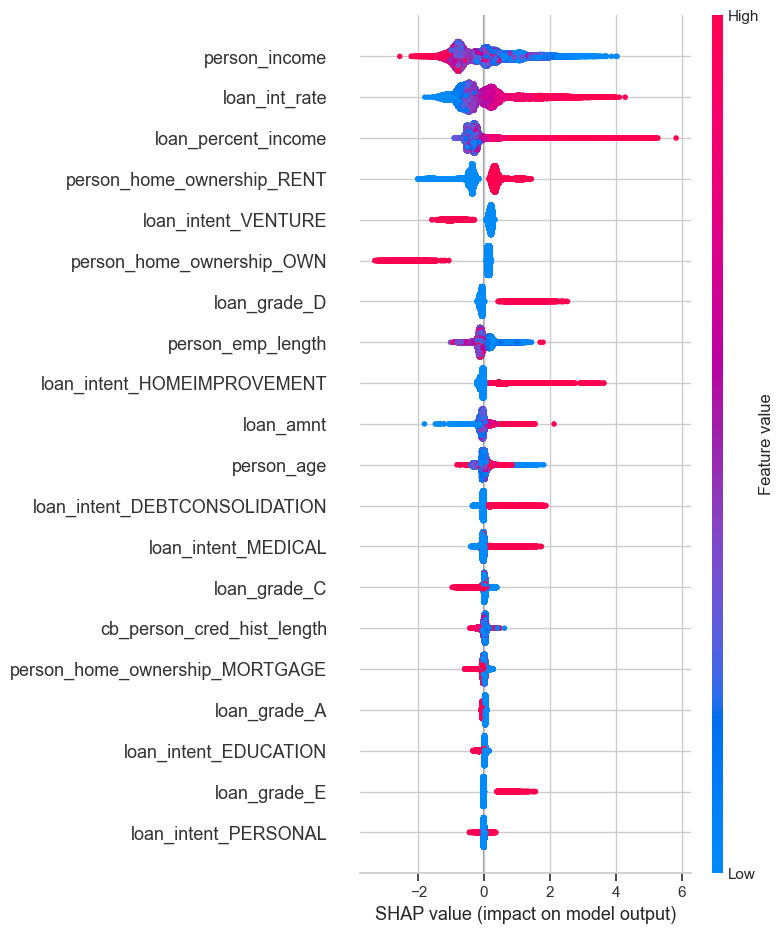

In [ ]:
import shap

# 使用 SHAP 來解釋模型
explainer_lgbm = shap.TreeExplainer(best_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(input_df.drop(columns=['id',TARGET]))

explainer_cat = shap.TreeExplainer(best_cat)
shap_values_cat = explainer_cat.shap_values(input_df.drop(columns=['id',TARGET]))

# 合併 SHAP 值
shap_values_combined = np.mean([shap_values_lgbm, shap_values_cat], axis=0)

# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[1], input_df.drop(columns=['id',TARGET]))

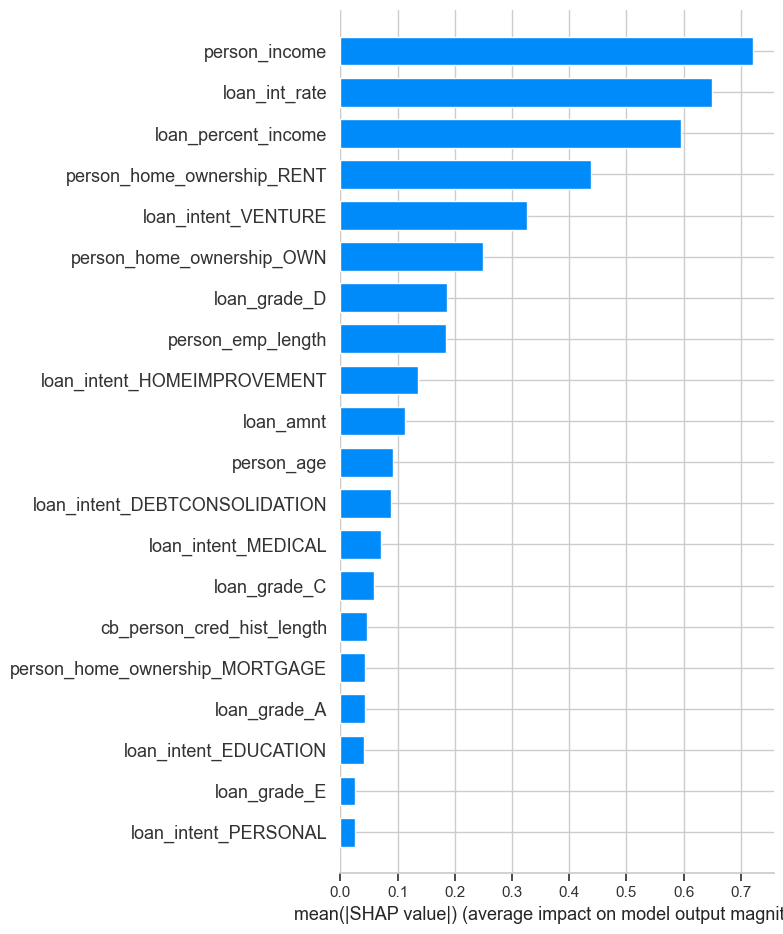

In [ ]:
# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[1], input_df.drop(columns=['id',TARGET]), plot_type='bar')

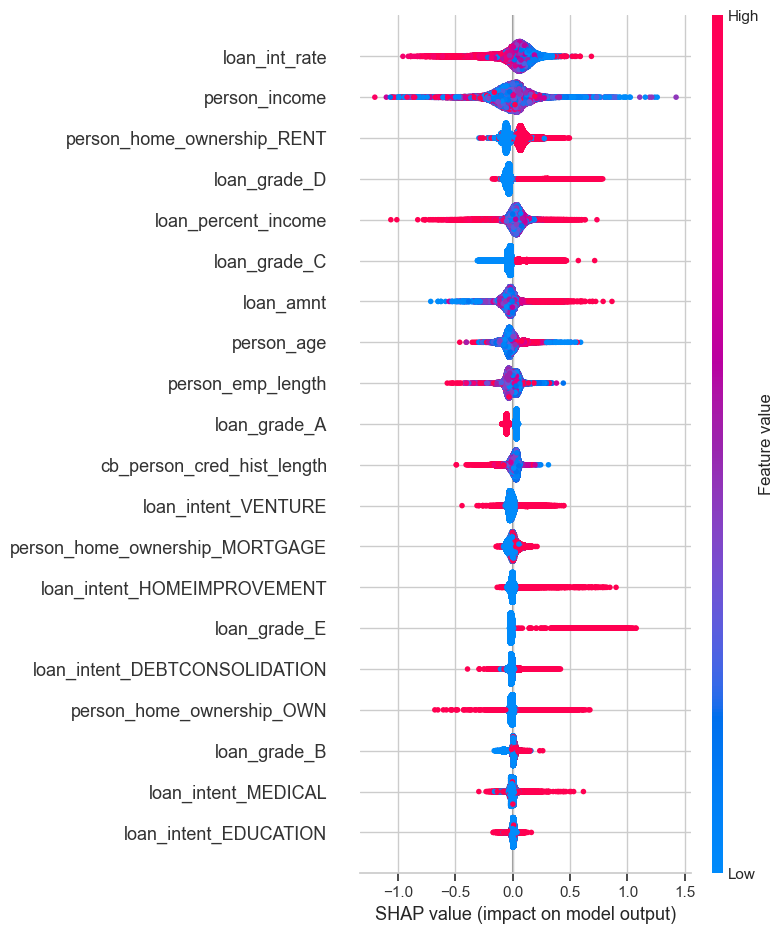

In [ ]:
# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[0], input_df.drop(columns=['id',TARGET]))

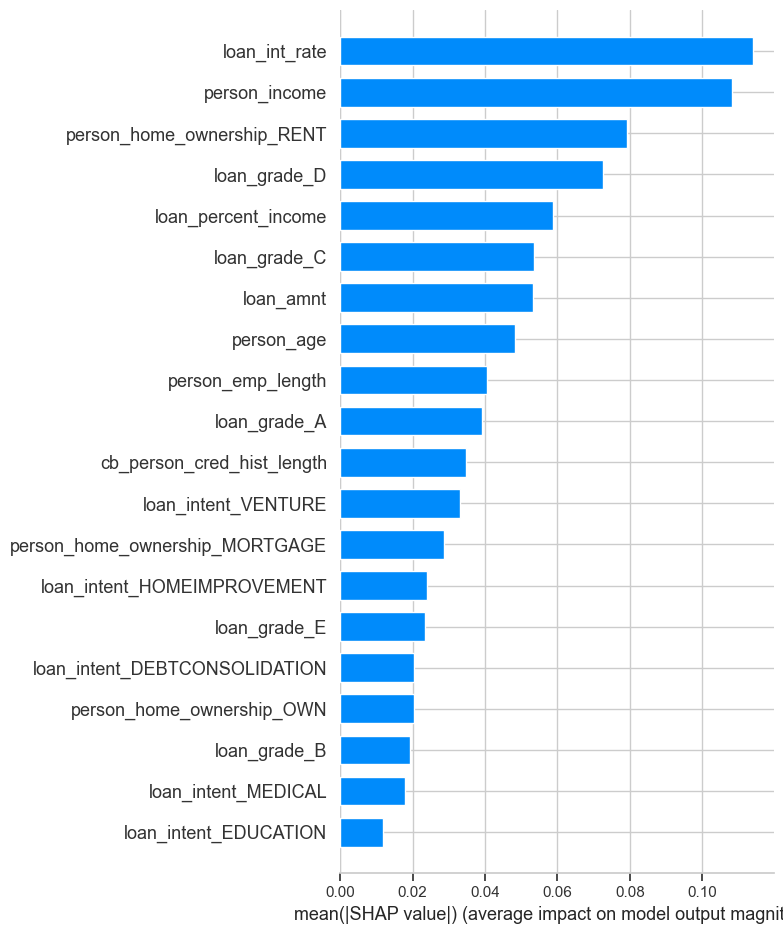

In [ ]:
# 繪製 SHAP 值
shap.summary_plot(shap_values_combined[0], input_df.drop(columns=['id',TARGET]), plot_type='bar')

In [ ]:
input_df.drop(columns=['id',TARGET]).columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'mid_risk', 'high_risk', 'max_risk', 'mid_risk_person_age',
       'mid_risk_person_income', 'mid_risk_loan_amnt',
       'mid_risk_cb_person_cred_hist_length', 'mid_risk_person_emp_length',
       'mid_risk_loan_int_rate', 'mid_risk_loan_percent_income',
       'high_risk_person_age', 'high_risk_person_income',
       'high_risk_loan_amnt', 'high_risk_cb_person_cred_hist_length',
       'high_risk_person_emp_length', 'high_risk_loan_int_rate',
       'high_risk_loan_percent_income', 'max_risk_person_age',
       'max_risk_person_income', 'max_risk_loan_amnt',
       'max_risk_cb_person_cred_hist_length', 'max_risk_person_emp_length',
       'max_risk_loan_int_rate', 'max_risk_loan_percent_income',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'pe

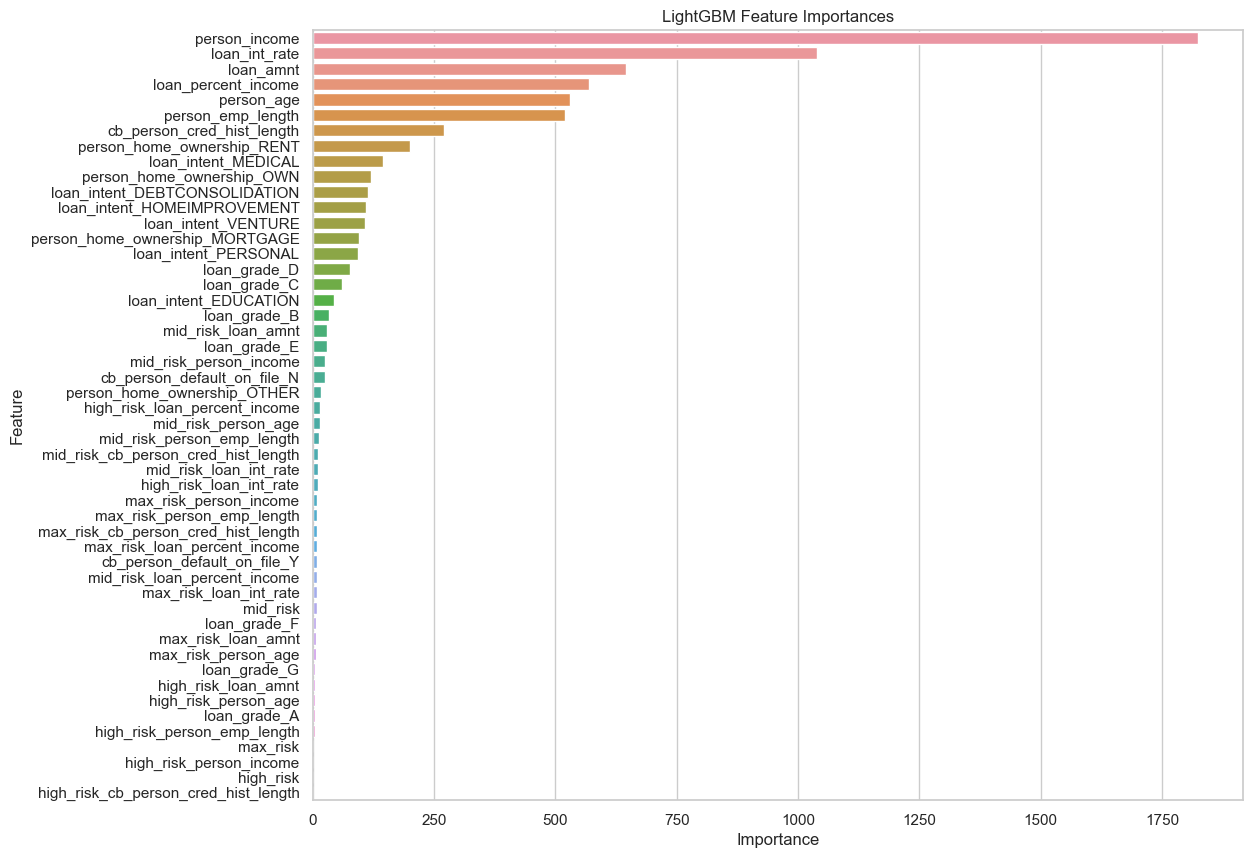

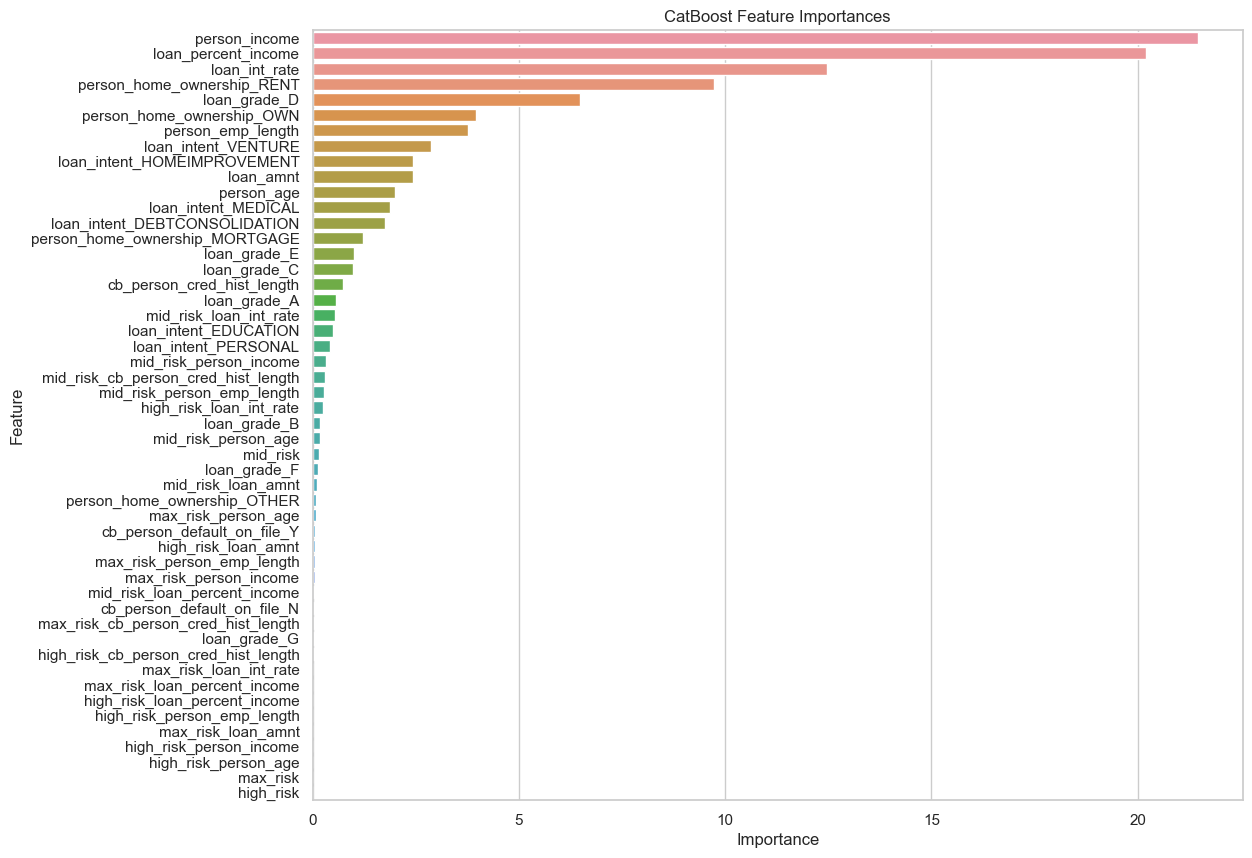

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract feature importances from the LightGBM model
lgbm_importances = best_lgbm.feature_importances_
lgbm_features = X_train.columns

# Extract feature importances from the CatBoost model
cat_importances = best_cat.get_feature_importance()
cat_features = X_train.columns

# Create a DataFrame for LightGBM feature importances
lgbm_importance_df = pd.DataFrame({
    'Feature': lgbm_features,
    'Importance': lgbm_importances
}).sort_values(by='Importance', ascending=False)

# Create a DataFrame for CatBoost feature importances
cat_importance_df = pd.DataFrame({
    'Feature': cat_features,
    'Importance': cat_importances
}).sort_values(by='Importance', ascending=False)

# Plot LightGBM feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=lgbm_importance_df)
plt.title('LightGBM Feature Importances')
plt.savefig('figure/lgbm_feature_importances.png')
plt.show()

# Plot CatBoost feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=cat_importance_df)
plt.title('CatBoost Feature Importances')
plt.savefig('figure/cat_feature_importances.png')
plt.show()

In [ ]:
y_proba = best_stack.predict_proba(input_df.drop(columns=['id',TARGET]))[:, 1]
y_test = input_df[TARGET]

# 計算不同閥值下的 Precision、Recall 和 Accuracy
thresholds = np.arange(0, 1.01, 0.01).round(5)
results = []

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    precision = round(precision_score(y_test, y_pred),5)
    recall = round(recall_score(y_test, y_pred),5)
    accuracy = round(accuracy_score(y_test, y_pred),5)
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })

# 將結果轉換為 DataFrame
results_df = pd.DataFrame(results)

In [ ]:
# 輸出結果
results_df.to_csv('threshold_results.csv', index=False)

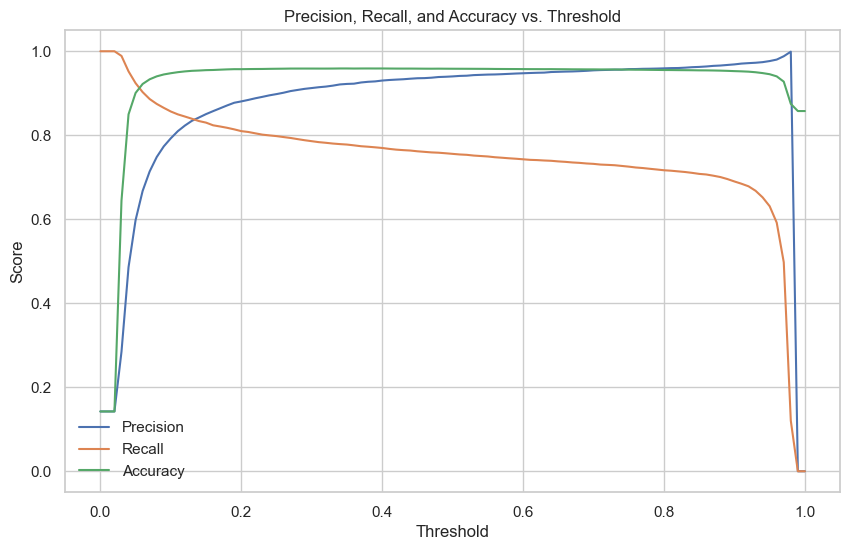

In [ ]:
# 繪製圖表
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='threshold', y='precision', label='Precision')
sns.lineplot(data=results_df, x='threshold', y='recall', label='Recall')
sns.lineplot(data=results_df, x='threshold', y='accuracy', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.savefig('figure/threshold_results.png')
plt.show()


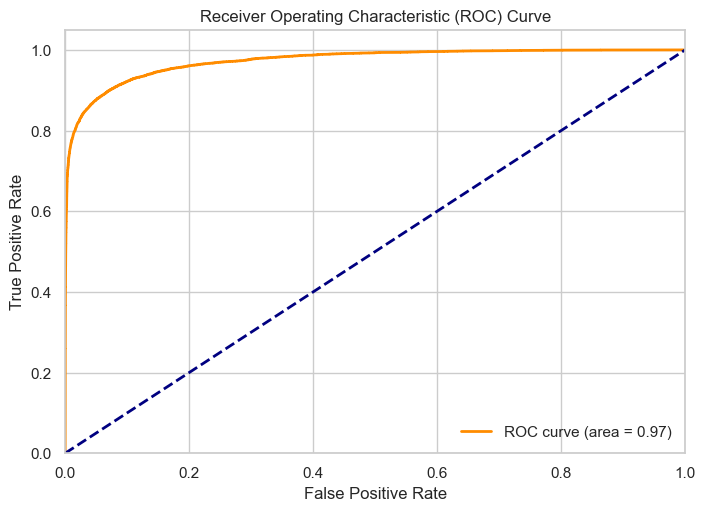

In [ ]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt


# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('figure/roc_curve.png')
plt.show()


In [ ]:
os.getcwd()

'c:\\Users\\johnn\\Loan-approval'

#### Subbmison

In [ ]:
test_df['mid_risk'] = test_df[['loan_grade', 'person_home_ownership','loan_intent']].apply(
    lambda x: 1 if x['loan_grade'] == 'D' and x['person_home_ownership']=='RENT' and x['loan_intent'] in ['MEDICAL','DEBTCONSOLIDATION'] else 0, axis=1)
test_df['high_risk'] = test_df[['loan_grade', 'person_home_ownership','loan_intent']].apply(
    lambda x: 1 if x['loan_grade'] == 'E' and x['person_home_ownership']=='RENT' and x['loan_intent'] in ['MEDICAL','DEBTCONSOLIDATION'] else 0, axis=1)
test_df['max_risk'] = test_df[['loan_grade', 'person_home_ownership','loan_intent', 'cb_person_default_on_file']].apply(
    lambda x: 1 if x['loan_grade'] == 'D' and x['person_home_ownership']=='RENT' and x['loan_intent'] in ['MEDICAL','DEBTCONSOLIDATION'] and x['cb_person_default_on_file']=='Y' else 0, axis=1)

In [ ]:
test_df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,mid_risk,high_risk,max_risk
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,0,0,0
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,0,0,0
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,0,0,0
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,0,0,0
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4,0,0,0
39094,97739,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3,0,0,0
39095,97740,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25,0,0,0
39096,97741,22,36000,MORTGAGE,4.0,PERSONAL,D,14000,15.62,0.39,Y,4,0,0,0


In [ ]:
for i in ['mid_risk', 'high_risk', 'max_risk']:
    for j in use_int + float_columns:
        test_df[f'{i}_{j}'] = test_df[i] * test_df[j]

In [ ]:
input_sub_df, mapping_sub_df = preprocessor.preprocess(df=test_df,
                                                    one_hot_columns=['loan_grade','person_home_ownership', 'loan_intent', 'cb_person_default_on_file'])

In [ ]:
input_sub_df

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,mid_risk,high_risk,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,58645,23,69000,3.0,25000,15.76,0.36,2,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,58646,26,96000,6.0,10000,12.68,0.10,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,58647,26,30000,5.0,4000,17.19,0.13,2,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,58648,33,50000,4.0,7000,8.90,0.14,7,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,58649,26,102000,8.0,15000,16.32,0.15,4,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,2.0,3000,10.37,0.10,4,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39094,97739,22,48000,6.0,7000,6.03,0.15,3,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
39095,97740,51,60000,0.0,15000,7.51,0.25,25,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
39096,97741,22,36000,4.0,14000,15.62,0.39,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
y_sub__proba = best_stack.predict_proba(input_sub_df.drop(columns='id'))[:, 1]

In [ ]:
sub_data = pd.DataFrame({
    'id': input_sub_df['id'],
    'loan_status': y_sub__proba
})

In [ ]:
sub_data.to_csv('submission.csv', index=False)

#### End

In [ ]:
694/1909

0.3635411210057622

In [ ]:
import tqdm

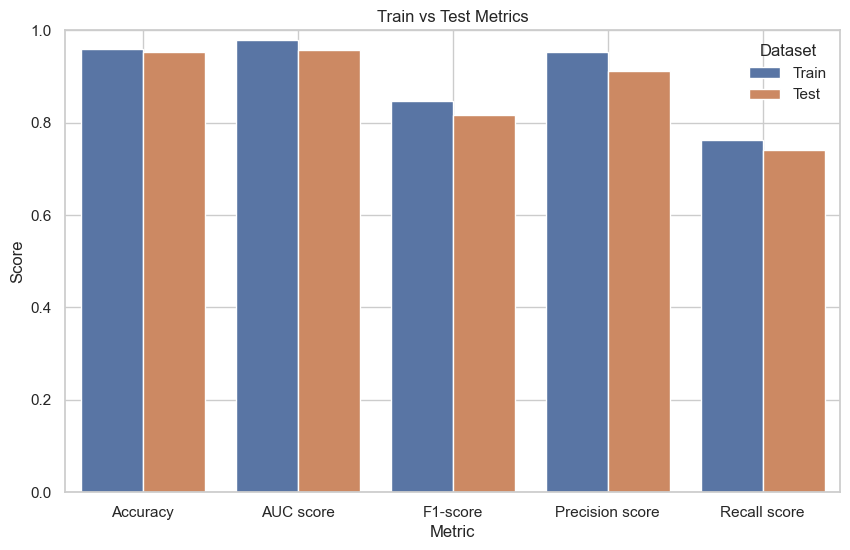

In [ ]:
# 定義數據
data_1 = {
    'Metric': ['Accuracy', 'AUC score', 'F1-score', 'Precision score', 'Recall score'],
    'Train': [0.9604881732479111, 0.9793043313498182, 0.8468077068379297, 0.9526136846578835, 0.7621557293437606],
    'Test': [0.9533932022280323, 0.9577666724313176, 0.8167188198480108, 0.9107676969092722, 0.7402755267423015]
}

# 將數據轉換為 DataFrame
df_1 = pd.DataFrame(data_1)

# 繪製條形圖
plt.figure(figsize=(10, 6))
df_melted = df_1.melt(id_vars='Metric', var_name='Dataset', value_name='Score')
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Dataset')
plt.title('Train vs Test Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Dataset')
plt.grid(True)
plt.show()

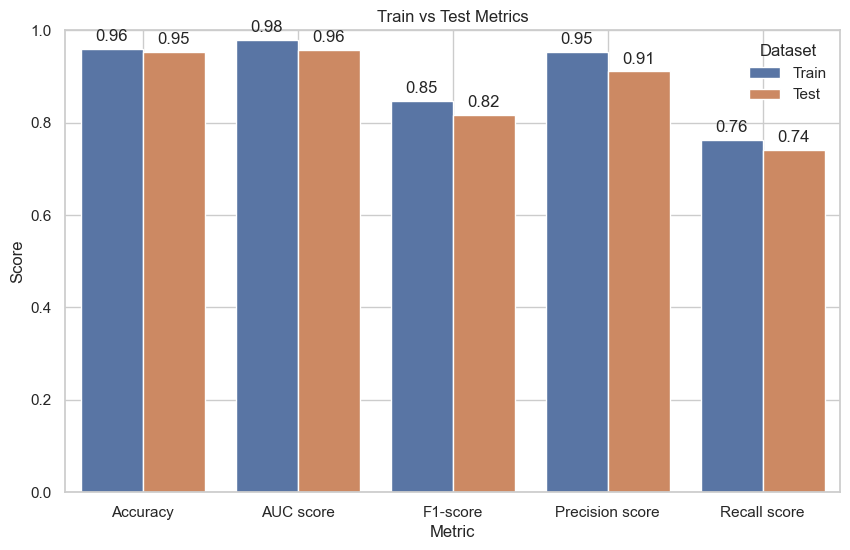

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 定義數據
data_1 = {
    'Metric': ['Accuracy', 'AUC score', 'F1-score', 'Precision score', 'Recall score'],
    'Train': [0.9604881732479111, 0.9793043313498182, 0.8468077068379297, 0.9526136846578835, 0.7621557293437606],
    'Test': [0.9533932022280323, 0.9577666724313176, 0.8167188198480108, 0.9107676969092722, 0.7402755267423015]
}

# 將數據轉換為 DataFrame
df_1 = pd.DataFrame(data_1)

# 繪製條形圖
plt.figure(figsize=(10, 6))
df_melted = df_1.melt(id_vars='Metric', var_name='Dataset', value_name='Score')
barplot = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Dataset')
plt.title('Train vs Test Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Dataset')
plt.grid(True)

# 在條形圖上顯示數字
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),  # 9 points vertical offset
                     textcoords = 'offset points')

plt.show()

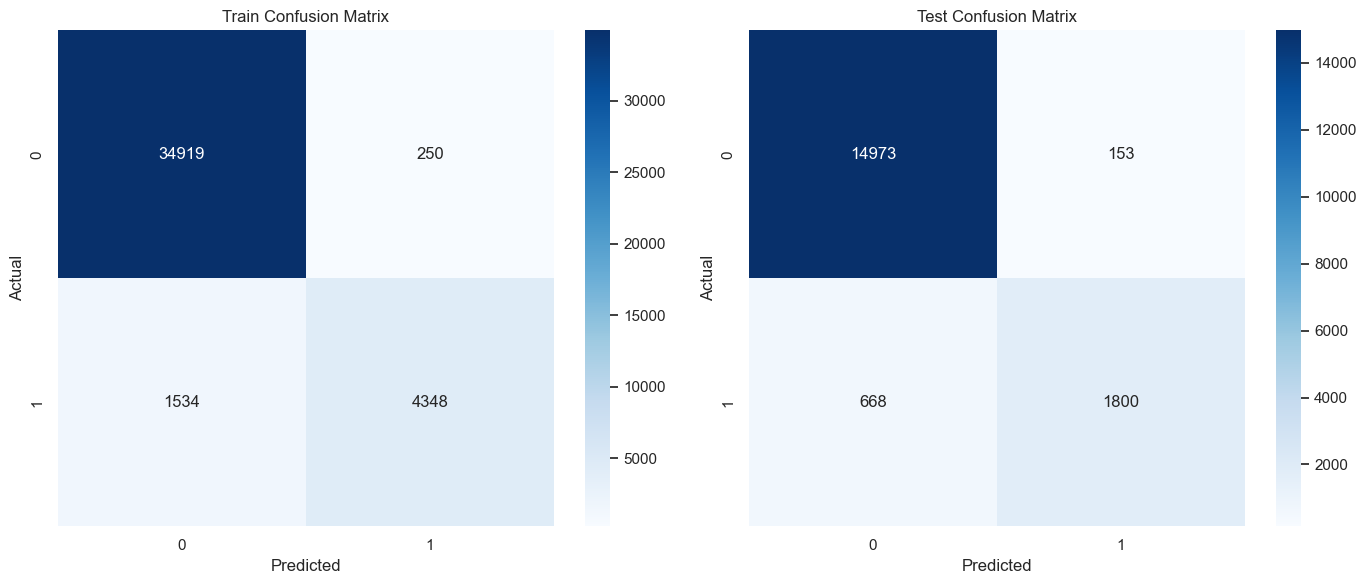

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 定義混淆矩陣數據
train_cm = np.array([[34919, 250], [1534, 4348]])
test_cm = np.array([[14973, 153], [668, 1800]])

# 繪製混淆矩陣
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 訓練集混淆矩陣
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 測試集混淆矩陣
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

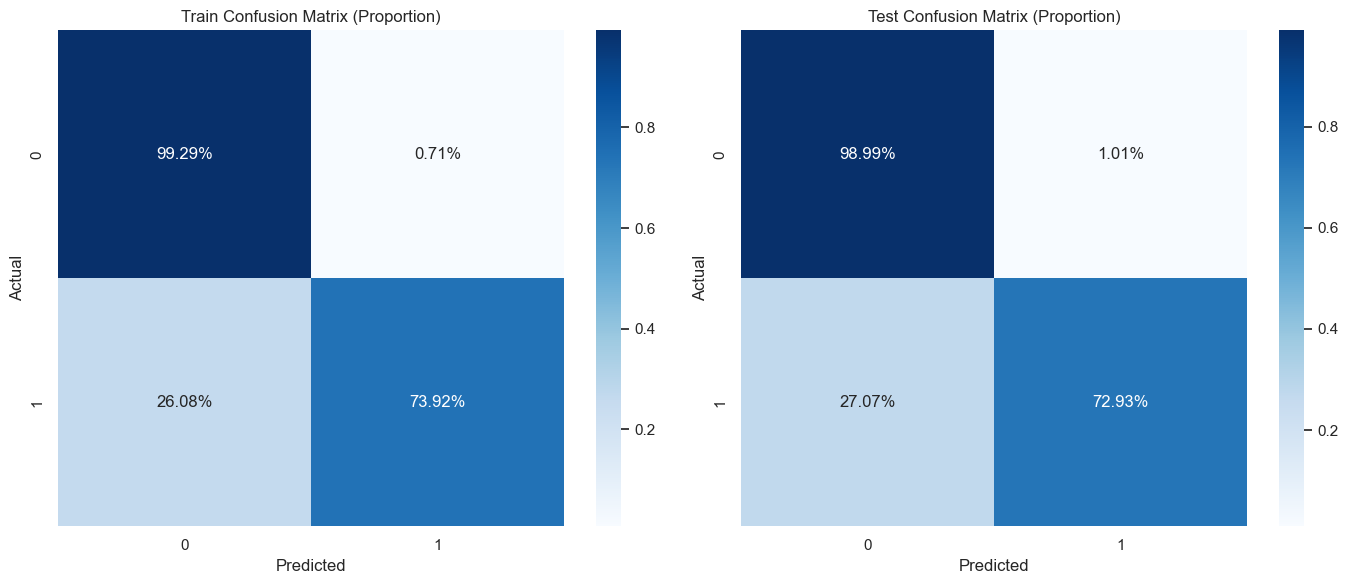

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 定義混淆矩陣數據
train_cm = np.array([[34919, 250], [1534, 4348]])
test_cm = np.array([[14973, 153], [668, 1800]])

# 計算比例
train_cm_proportion = train_cm / train_cm.sum(axis=1, keepdims=True)
test_cm_proportion = test_cm / test_cm.sum(axis=1, keepdims=True)

# 繪製混淆矩陣
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 訓練集混淆矩陣
sns.heatmap(train_cm_proportion, annot=True, fmt='.2%', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix (Proportion)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 測試集混淆矩陣
sns.heatmap(test_cm_proportion, annot=True, fmt='.2%', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix (Proportion)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

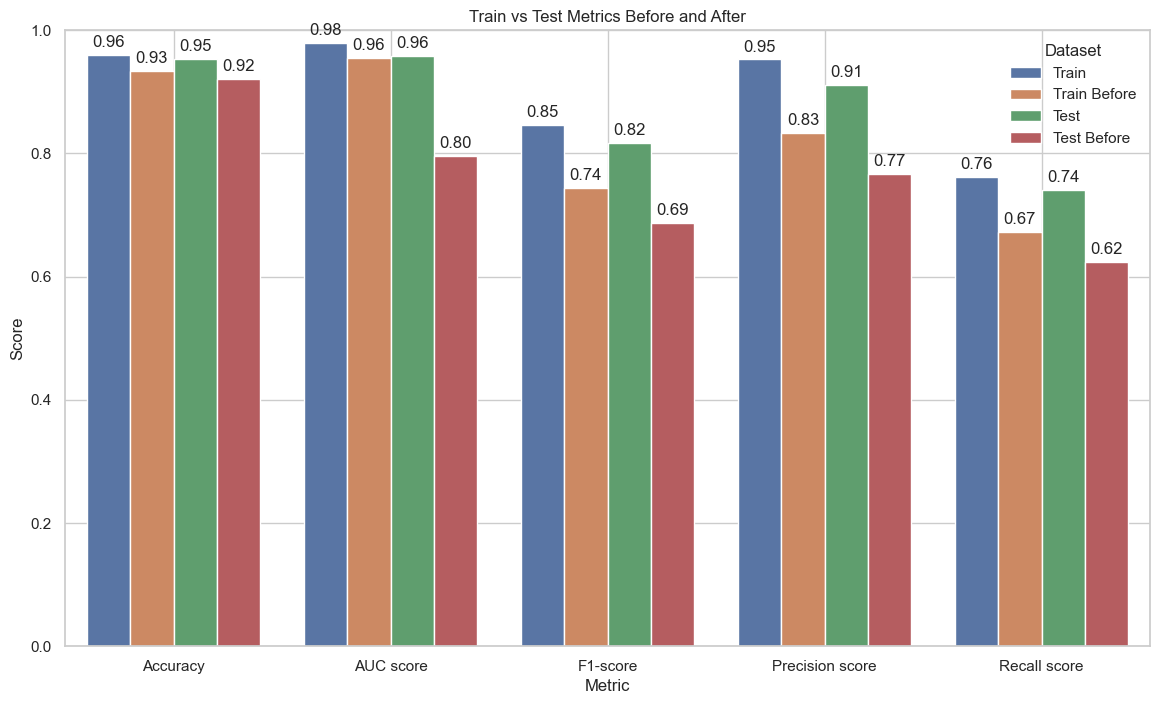

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 定義數據
data_2 = {
    'Metric': ['Accuracy', 'AUC score', 'F1-score', 'Precision score', 'Recall score'],
    'Train': [0.9604881732479111, 0.9793043313498182, 0.8468077068379297, 0.9526136846578835, 0.7621557293437606],
    'Train Before': [0.9338627560838957, 0.9557057248678744, 0.7447108603667136, 0.8331580054702293, 0.6732403944236655],
    'Test': [0.9533932022280323, 0.9577666724313176, 0.8167188198480108, 0.9107676969092722, 0.7402755267423015],
    'Test Before': [0.9205410935546209, 0.7964573541195075, 0.6878070567217508, 0.7661691542288557, 0.6239870340356564]
}

# 將數據轉換為 DataFrame
df_2 = pd.DataFrame(data_2)

# 繪製條形圖
plt.figure(figsize=(14, 8))
df_melted = df_2.melt(id_vars='Metric', var_name='Dataset', value_name='Score')
barplot = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Dataset')
plt.title('Train vs Test Metrics Before and After')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Dataset')
plt.grid(True)

# 在條形圖上顯示數字
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),  # 9 points vertical offset
                     textcoords = 'offset points')

plt.show()

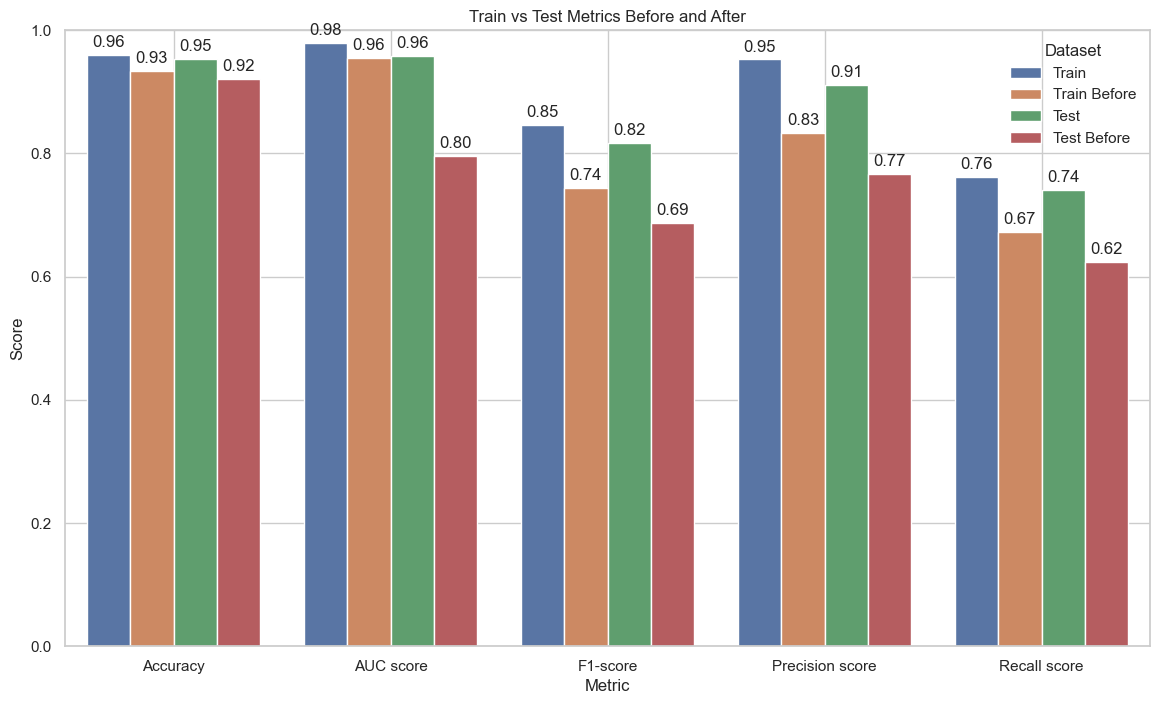

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 定義數據
data_2 = {
    'Metric': ['Accuracy', 'AUC score', 'F1-score', 'Precision score', 'Recall score'],
    'Train': [0.9604881732479111, 0.9793043313498182, 0.8468077068379297, 0.9526136846578835, 0.7621557293437606],
    'Train Before': [0.9338627560838957, 0.9557057248678744, 0.7447108603667136, 0.8331580054702293, 0.6732403944236655],
    'Test': [0.9533932022280323, 0.9577666724313176, 0.8167188198480108, 0.9107676969092722, 0.7402755267423015],
    'Test Before': [0.9205410935546209, 0.7964573541195075, 0.6878070567217508, 0.7661691542288557, 0.6239870340356564]
}

# 將數據轉換為 DataFrame
df_2 = pd.DataFrame(data_2)

# 繪製條形圖
plt.figure(figsize=(14, 8))
df_melted = df_2.melt(id_vars='Metric', var_name='Dataset', value_name='Score')
barplot = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Dataset', palette='deep')
plt.title('Train vs Test Metrics Before and After')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Dataset')
plt.grid(True)

# 在條形圖上顯示數字
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),  # 9 points vertical offset
                     textcoords = 'offset points')

plt.show()

In [ ]:
## 7.2 商業建議

基於分析結果，提出以下建議：

### 風險評估改善
1. **重點關注貸款等級**：作為最重要的預測因子，應確保等級評估的準確性
2. **收入驗證**：加強對申請人收入的驗證，特別是收入與貸款金額的比例
3. **年齡考量**：年輕申請人可能需要額外的風險評估措施

### 模型部署建議
1. **實時預測**：可將最終模型部署為實時預測系統
2. **定期重訓**：建議每季度重新訓練模型以適應新數據
3. **監控指標**：持續監控模型的 AUC、精確率和召回率

### 特徵監控
1. **新特徵探索**：可考慮添加更多外部數據源（如信用評分、就業穩定性等）
2. **特徵重要性追蹤**：定期檢查特徵重要性的變化
3. **A/B 測試**：對新特徵進行 A/B 測試驗證

## 7.3 後續步驟

1. **模型驗證**：在更大的測試集上驗證模型性能
2. **集成方法**：嘗試結合多個模型的集成方法
3. **解釋性分析**：使用 SHAP 等工具提供模型解釋
4. **生產部署**：準備模型的生產環境部署

---

**專案完成日期：** 2025年8月4日  
**模型最終性能：** AUC ≈ 0.958  
**關鍵改善：** 相較基準模型提升約 16% 的 AUC 性能

: 